In [482]:
import os
import re
import pickle
import shutil
from functions import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [483]:
path = 'GoT_files'

pages = os.listdir(path)
page_titles = [f for f in pages if not f.startswith('fetched_pages_')]
page_titles = [f for f in page_titles if not f.startswith('redirects_')]
page_titles = [f for f in page_titles if not f.startswith('failed_pages_')]

In [484]:
def load_all_files(path: str = 'GoT_files') -> dict:
    pages = os.listdir(path)

    page_titles = [f for f in pages if not f.startswith('fetched_pages_')]
    page_titles = [f for f in page_titles if not f.startswith('redirects_')]
    page_titles = [f for f in page_titles if not f.startswith('failed_pages_')]

    page_texts = {}

    for file in pages:
        # Skip files in Doubles subfolder and skip directories
        if file == 'Doubles' or os.path.isdir(os.path.join(path, file)):
            continue
            
        page_name =  file.replace(".txt", "")
        text = load_text_files(file,path)
        page_texts[page_name] = text
    
    return page_texts

page_texts = load_all_files()

In [485]:
def get_links_by_section(file: str, path: str = 'GoT_files', no_files: bool = True, no_translations: bool = True) -> dict:
    """Extract links from a wiki page, organized by section.
    
    Args:
        file: Filename to read (e.g., 'Page Name.txt')
        path: Directory containing the file
        no_files: If True, exclude File: and Image: links
        no_translations: If True, exclude translation links (e.g., [[de:...]])
    
    Returns:
        Dictionary with structure:
        {
            'sections': {
                'Section Name': {
                    'subsections': {
                        'Subsection Name': ['link1', 'link2', ...],
                        ...
                    },
                    'links': ['link1', 'link2', ...]  # Links directly under this section
                },
                ...
            },
            'header': ['link1', 'link2', ...],  # Links before first section
            'categories': ['category1', 'category2', ...]  # Links after <!--Categories-->
        }
    """
    
    with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Build regex pattern for links
    if no_files and no_translations:
        link_pattern = r"\[\[(?!\w{2,5}(?:-\w{2})?:)(?!File:)(?!Image:)(.+?)\]\]"
    elif no_files:
        link_pattern = r"\[\[(?!File:)(?!Image:)(.+?)\]\]"
    elif no_translations:
        link_pattern = r"\[\[(?!\w{2,5}(?:-\w{2})?:)(.+?)\]\]"
    else:
        link_pattern = r"\[\[(.+?)\]\]"
    
    result = {
        'sections': {},
        'header': [],
        'categories': []
    }
    
    # Split text into parts
    lines = text.split('\n')
    
    current_section = None
    current_subsection = None
    in_categories = False
    
    for i, line in enumerate(lines):
        # Check if we've reached categories
        if '<!--Categories-->' in line:
            in_categories = True
            continue
        
        # Check for section headers
        section_match = re.match(r'^==(.*?)==\s*$', line)
        subsection_match = re.match(r'^===(.*?)===\s*$', line)
        
        if section_match and not subsection_match:
            # Main section (== Section ==)
            current_section = section_match.group(1).strip()
            current_subsection = None
            if current_section not in result['sections']:
                result['sections'][current_section] = {
                    'subsections': {},
                    'links': []
                }
        elif subsection_match:
            # Subsection (=== Subsection ===)
            current_subsection = subsection_match.group(1).strip()
            if current_section:
                if current_subsection not in result['sections'][current_section]['subsections']:
                    result['sections'][current_section]['subsections'][current_subsection] = []
        
        # Extract links from this line
        matches = re.findall(link_pattern, line)
        
        for match in matches:
            # Clean the link (remove pipe syntax)
            if '|' in match:
                link = match.split('|')[0]
            else:
                link = match
            
            # Skip category links in normal sections
            if link.startswith('Category:') or link.startswith('category:'):
                if in_categories:
                    result['categories'].append(link.replace('Category:', '').replace('category:', ''))
                continue
            
            # Add to appropriate location
            if in_categories:
                continue  # Skip non-category links after <!--Categories-->
            elif current_subsection and current_section:
                result['sections'][current_section]['subsections'][current_subsection].append(link)
            elif current_section:
                result['sections'][current_section]['links'].append(link)
            else:
                result['header'].append(link)
    
    return result

In [486]:
# Test the new function on one page
test_sections = get_links_by_section('A Golden Crown.txt')

# Print structure
print("Header links:", len(test_sections['header']))
print("\nSections:", list(test_sections['sections'].keys()))
print("\nCategories:", test_sections['categories'][:5], "...")

# Example: What's in the Synopsis section?
if 'Synopsis' in test_sections['sections']:
    synopsis = test_sections['sections']['Synopsis']
    print("\nSynopsis subsections:", list(synopsis['subsections'].keys()))
    print("Synopsis direct links:", synopsis['links'][:5] if len(synopsis['links']) > 0 else "none")

Header links: 14

Sections: ['Premise', 'Synopsis', 'Appearances', 'Cast', 'Quotes', 'Behind the scenes', 'In the books', 'Gallery', 'References', 'External links']

Categories: ['Episodes directed by Daniel Minahan', 'Episodes of Game of Thrones: Season 1', 'Episodes released in 2011', 'Episodes written by D.B. Weiss', 'Episodes written by David Benioff'] ...

Synopsis subsections: ['In the Crownlands', 'In the North', 'At the Eyrie', 'In Vaes Dothrak']
Synopsis direct links: none


In [487]:
# Build graph with section information
DG_sections = nx.DiGraph()

# First pass: add all nodes
for page in page_texts.keys():
    DG_sections.add_node(page)

print(f"Added {DG_sections.number_of_nodes()} nodes")

Added 5672 nodes


In [488]:
# Second pass: add edges with section information and node attributes
category_map = load_category_mapping()

def extract_aka_names(text: str) -> list:
    """Extract AKA names from the Character infobox.
    
    Returns:
        List of alternative names for the character (empty list if no AKA names)
    """
    aka_names = []
    # Look for | AKA = in the Character template
    aka_match = re.search(r'\|\s*AKA\s*=\s*(.+?)(?=\n\||\n}})', text, re.DOTALL | re.IGNORECASE)
    if aka_match:
        aka_text = aka_match.group(1).strip()
        # Return empty list if AKA field is empty, only whitespace, or starts with | (next field)
        if not aka_text or aka_text.startswith('|'):
            return []
        
        # Split by <br> tags (common separator)
        parts = re.split(r'<br\s*/?>', aka_text, flags=re.IGNORECASE)
        for part in parts:
            # Remove wiki markup like {{Ref|...}} and {{C|...}}
            cleaned = re.sub(r'\{\{[^}]+\}\}', '', part)
            # Remove any remaining brackets and extra whitespace
            cleaned = re.sub(r'[\[\]]', '', cleaned).strip()
            # Don't add if it starts with | (indicates we captured the next field)
            if cleaned and not cleaned.startswith('|'):
                aka_names.append(cleaned)
    return aka_names

# Character categories to check
character_categories = {
    'Individuals from Game of Thrones',
    'Individuals from House of the Dragon',
    'Individuals from A Knight of the Seven Kingdoms',
    'Individuals appearing in Game of Thrones',
    'Individuals appearing in House of the Dragon',
    'Individuals appearing in A Knight of the Seven Kingdoms',
}

for page in page_texts.keys():
    file = page + '.txt'
    section_data = get_links_by_section(file)
    
    # Store categories as node attribute
    cleaned_categories = clean_categories(section_data['categories'], category_map)
    DG_sections.nodes[page]['categories'] = cleaned_categories
    
    # Extract and store AKA names only for character nodes
    if any(cat in character_categories for cat in cleaned_categories):
        page_text = page_texts[page]
        aka_names = extract_aka_names(page_text)
        if aka_names:
            DG_sections.nodes[page]['also_known_as'] = aka_names
    
    # Process header links
    for link in section_data['header']:
        if link in DG_sections.nodes():
            # Check if edge already exists
            if DG_sections.has_edge(page, link):
                # Add to existing sections list
                DG_sections[page][link]['sections'].append('header')
            else:
                # Create new edge with sections list
                DG_sections.add_edge(page, link, sections=['header'])
    
    # Process section links
    for section_name, section_content in section_data['sections'].items():
        # Links directly under section
        for link in section_content['links']:
            if link in DG_sections.nodes():
                section_label = section_name
                if DG_sections.has_edge(page, link):
                    DG_sections[page][link]['sections'].append(section_label)
                else:
                    DG_sections.add_edge(page, link, sections=[section_label])
        
        # Links in subsections
        for subsection_name, links in section_content['subsections'].items():
            for link in links:
                if link in DG_sections.nodes():
                    section_label = f"{section_name} > {subsection_name}"
                    if DG_sections.has_edge(page, link):
                        DG_sections[page][link]['sections'].append(section_label)
                    else:
                        DG_sections.add_edge(page, link, sections=[section_label])
    
    # Process categories as edges
    for cat in cleaned_categories:
        if cat in DG_sections.nodes():
            if DG_sections.has_edge(page, cat):
                DG_sections[page][cat]['sections'].append('categories')
            else:
                DG_sections.add_edge(page, cat, sections=['categories'])

print(f"Graph has {DG_sections.number_of_nodes()} nodes and {DG_sections.number_of_edges()} edges")

Graph has 5672 nodes and 198768 edges


In [489]:
# Test AKA extraction for character nodes
if 'Jon Snow' in DG_sections.nodes():
    aka = DG_sections.nodes['Jon Snow'].get('also_known_as', [])
    categories = DG_sections.nodes['Jon Snow'].get('categories', [])
    print(f"Jon Snow categories: {categories[:3]}...")
    print(f"\nJon Snow is also known as:")
    for name in aka:
        print(f"  - {name}")
else:
    print("Jon Snow not found in nodes")

# Count how many characters have AKA names
nodes_with_aka = [n for n in DG_sections.nodes() if DG_sections.nodes[n].get('also_known_as')]
print(f"\n{len(nodes_with_aka)} character nodes have 'also_known_as' attribute")

Jon Snow categories: ['Bannermen of House Stark', "Deserters of the Night's Watch", 'Dragonriders']...

Jon Snow is also known as:
  - Lord Snow
  - King Crow
  - The White Wolf
  - The Bastard of Winterfell

115 character nodes have 'also_known_as' attribute


In [490]:
# Example: Examine edges from a specific page
page_name = 'A Golden Crown'
if page_name in DG_sections.nodes():
    edges = DG_sections.out_edges(page_name, data=True)
    print(f"Edges from '{page_name}':\n")
    
    # Show first 10 edges with their section information
    for i, (source, target, data) in enumerate(list(edges)[:10]):
        sections = data.get('sections', [])
        print(f"{i+1}. {target}")
        print(f"   Sections: {', '.join(sections)}")
    
    print(f"\n... and {len(list(edges)) - 10} more edges")

Edges from 'A Golden Crown':

1. Jane Espenson
   Sections: header, header
2. David Benioff
   Sections: header, header
3. D.B. Weiss
   Sections: header, header
4. Daniel Minahan
   Sections: header, header
5. The Wolf and the Lion
   Sections: header
6. You Win or You Die
   Sections: header
7. Game of Thrones
   Sections: header
8. HBO
   Sections: header
9. Jaime Lannister
   Sections: Synopsis > In the Crownlands, Cast > Notes
10. Robert Baratheon
   Sections: Synopsis > In the Crownlands, Cast > Starring, Quotes

... and 161 more edges


## Building the GoT episode graph

In [492]:
DG_sections.nodes['A Golden Crown'].get('categories')

['Episodes directed by Daniel Minahan',
 'Episodes of Game of Thrones: Season 1',
 'Episodes released in 2011',
 'Episodes written by D.B. Weiss',
 'Episodes written by David Benioff',
 'Episodes written by Jane Espenson']

In [493]:
for item in DG_sections.nodes['David Benioff'].get('categories'):
    if 'writer' in item.lower():
        print(item)

Writers of Game of Thrones


In [494]:
episode_cats = []
dir_cats = []
writer_cats = []
for page in list(DG_sections.nodes()):
    for category in DG_sections.nodes[page].get('categories'):
        if 'episode' in category.lower() and category not in episode_cats:
            episode_cats.append(category)
        if 'writer' in category.lower() and category not in writer_cats:
            writer_cats.append(category)
        if 'director' in category.lower() and category not in dir_cats:
            dir_cats.append(category)

In [495]:
DG_sections.nodes['A Nest of Vipers'].get('categories')

['Episodes directed by Jason Latino',
 'Episodes of Game of Thrones: A Telltale Games Series',
 'Episodes released in 2015',
 'Episodes written by Brad Kane',
 'Episodes written by Meghan Thornton']

In [496]:
# Identify GoT episodes, writers, and directors
got_nodes = set()
node_types = {}

for node in DG_sections.nodes():
    node_type = []
    for category in DG_sections.nodes[node].get('categories', []):
        if 'Episodes of Game of Thrones: Season' in category:
            node_type.append('episode')
        if 'Directors of Game of Thrones' == category:
            node_type.append('director')
        if 'Writers of Game of Thrones' == category:
            node_type.append('writer')
    
    if node_type:
        got_nodes.add(node)
        node_types[node] = node_type

# Create empty graph (we'll add our own edges with relation attributes)
GOT_G = nx.Graph()

# Add nodes with type attributes
for node in got_nodes:
    GOT_G.add_node(node, type=node_types[node])

In [497]:
episodes = [n for n in GOT_G.nodes() if 'episode' in GOT_G.nodes[n].get('type') ]

In [499]:
writers = [n for n in GOT_G.nodes() if 'writer' in GOT_G.nodes[n].get('type') ]

In [500]:
directors = [n for n in GOT_G.nodes() if 'director' in GOT_G.nodes[n].get('type')]

In [501]:
writer_director = []
for writer in writers:
    if writer in directors:
        writer_director.append(writer)

In [502]:
DG_sections.has_edge('Jon Snow', 'Sansa Stark')

True

In [503]:
for episode in episodes:
    count = 0
    for wr in writer_director:
        if f'Episodes written by {wr}' in DG_sections.nodes[episode].get('categories') and f'Episodes directed by {wr}' in DG_sections.nodes[episode].get('categories'):
            print(wr)


D.B. Weiss
David Benioff
David Benioff
D.B. Weiss


In [504]:
# Add edges based on episode categories (written by / directed by)
for episode in episodes:
    episode_cats = DG_sections.nodes[episode].get('categories', [])
    
    for writer in writers:
        if f'Episodes written by {writer}' in episode_cats:
            if GOT_G.has_edge(episode, writer):
                relations = GOT_G.edges[episode, writer].get('relation', [])
                if 'written by' not in relations:
                    relations.append('written by')
            else:
                GOT_G.add_edge(episode, writer, relation=['written by'])
    
    for director in directors:
        if f'Episodes directed by {director}' in episode_cats:
            if GOT_G.has_edge(episode, director):
                relations = GOT_G.edges[episode, director].get('relation', [])
                if 'directed by' not in relations:
                    relations.append('directed by')
            else:
                GOT_G.add_edge(episode, director, relation=['directed by'])


In [505]:
GOT_G.edges['A Golden Crown','D.B. Weiss'].get('relation', [])

['written by']

In [506]:
for edges in list(GOT_G.edges()):
    if 'written by' in GOT_G.edges[edges[0],edges[1]].get('relation', []) and 'directed by' in GOT_G.edges[edges[0],edges[1]].get('relation', []):
        print(edges)

('The Iron Throne', 'D.B. Weiss')
('The Iron Throne', 'David Benioff')
('D.B. Weiss', 'Two Swords')
('Walk of Punishment (episode)', 'David Benioff')


In [507]:
GOT_G.edges['The Iron Throne','D.B. Weiss'].get('relation', [])

['written by', 'directed by']

In [508]:
# Create layout
pos_got = nx.forceatlas2_layout(GOT_G)

GOT_G network: 73 episodes, 5 writers, 12 directors
Total edges: 167


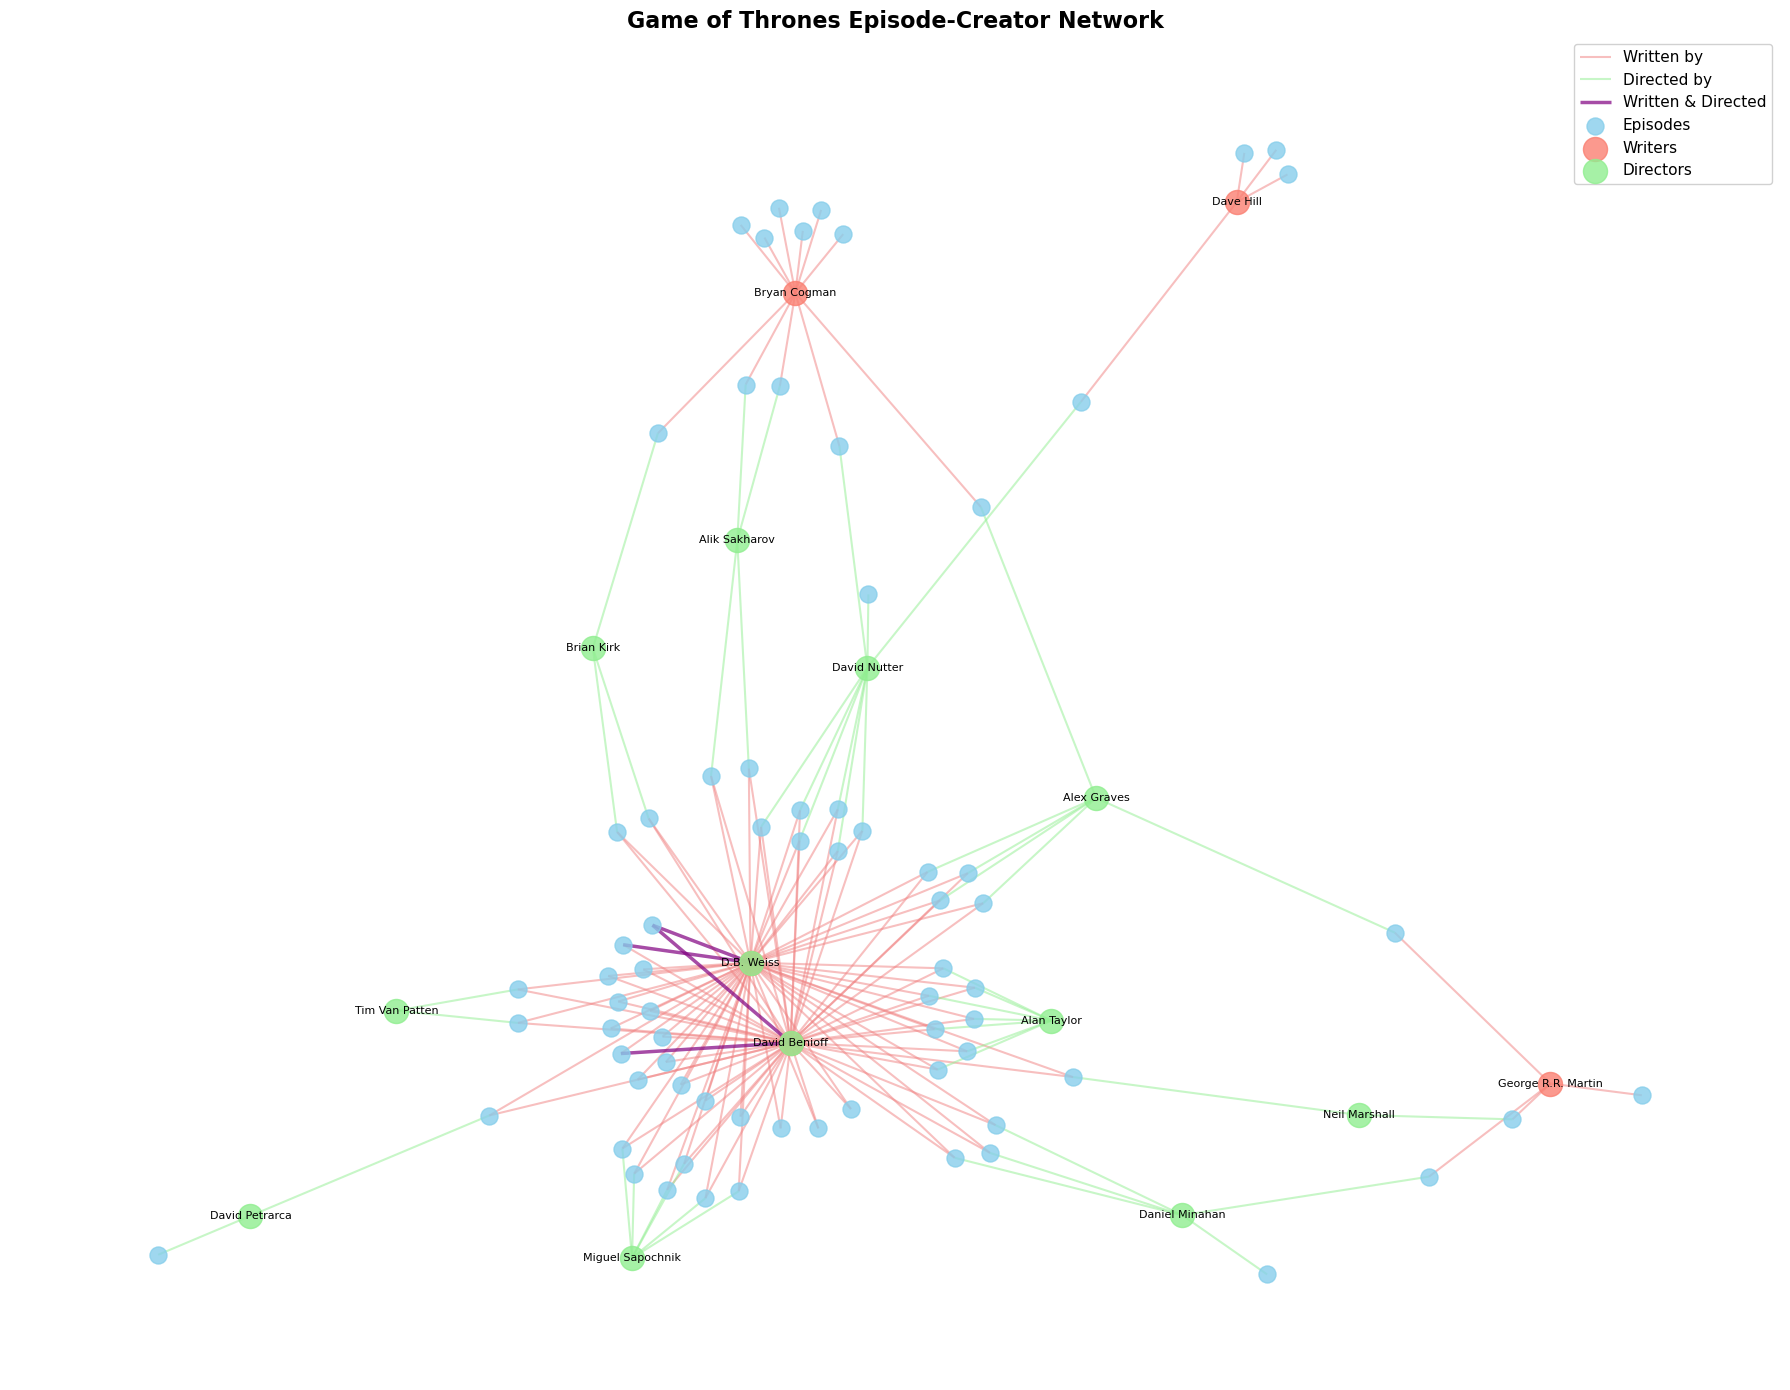


Edge breakdown:
  Written by only: 117
  Directed by only: 46
  Both written & directed: 4


In [511]:
# Visualize GOT_G network with colored nodes and edges
# Get node types
episodes = [n for n in GOT_G.nodes() if 'episode' in GOT_G.nodes[n].get('type', [])]
writers = [n for n in GOT_G.nodes() if 'writer' in GOT_G.nodes[n].get('type', [])]
directors = [n for n in GOT_G.nodes() if 'director' in GOT_G.nodes[n].get('type', [])]

print(f"GOT_G network: {len(episodes)} episodes, {len(writers)} writers, {len(directors)} directors")
print(f"Total edges: {GOT_G.number_of_edges()}")



# Create figure
fig, ax = plt.subplots(figsize=(18, 14))

# Categorize edges by relation type
written_edges = []
directed_edges = []
both_edges = []

for u, v in GOT_G.edges():
    relations = GOT_G.edges[u, v].get('relation', [])
    has_written = 'written by' in relations
    has_directed = 'directed by' in relations
    
    if has_written and has_directed:
        both_edges.append((u, v))
    elif has_written:
        written_edges.append((u, v))
    elif has_directed:
        directed_edges.append((u, v))

# Draw edges by type with different colors
nx.draw_networkx_edges(GOT_G, pos_got, edgelist=written_edges, 
                        edge_color='lightcoral', alpha=0.5, 
                        width=1.5, label='Written by', ax=ax)
nx.draw_networkx_edges(GOT_G, pos_got, edgelist=directed_edges, 
                        edge_color='lightgreen', alpha=0.5, 
                        width=1.5, label='Directed by', ax=ax)
nx.draw_networkx_edges(GOT_G, pos_got, edgelist=both_edges, 
                        edge_color='purple', alpha=0.7, 
                        width=2.5, label='Written & Directed', ax=ax)

# Draw nodes by type with different colors
nx.draw_networkx_nodes(GOT_G, pos_got, nodelist=episodes, 
                        node_color='skyblue', node_size=150, 
                        label='Episodes', alpha=0.8, ax=ax)
nx.draw_networkx_nodes(GOT_G, pos_got, nodelist=writers, 
                        node_color='salmon', node_size=300, 
                        label='Writers', alpha=0.8, ax=ax)
nx.draw_networkx_nodes(GOT_G, pos_got, nodelist=directors, 
                        node_color='lightgreen', node_size=300, 
                        label='Directors', alpha=0.8, ax=ax)

# Label writers and directors (and top episodes if desired)
labels = {n: n for n in writers + directors}
nx.draw_networkx_labels(GOT_G, pos_got, labels, font_size=8, ax=ax)

ax.set_title('Game of Thrones Episode-Creator Network', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"\nEdge breakdown:")
print(f"  Written by only: {len(written_edges)}")
print(f"  Directed by only: {len(directed_edges)}")
print(f"  Both written & directed: {len(both_edges)}")

In [512]:
# Save the character network
import pickle
with open(os.path.join('graphs', 'ep_director_graph.pickle'), 'wb') as f:
    pickle.dump(GOT_G, f)

print("Saved GOT_G to graphs/ep_director_graph.pickle")

Saved GOT_G to graphs/ep_director_graph.pickle


## Subgraph of links from the synopsis section only

In [513]:
# # Example: Create subgraph of only "Synopsis" section links
# synopsis_edges = []
# for source, target, data in DG_sections.edges(data=True):
#     sections = data.get('sections', [])
#     # Check if any section contains "Synopsis"
#     if any('Synopsis' in s for s in sections):
#         synopsis_edges.append((source, target))

# DG_synopsis = DG_sections.edge_subgraph(synopsis_edges).copy()
# print(f"Synopsis subgraph: {DG_synopsis.number_of_nodes()} nodes, {DG_synopsis.number_of_edges()} edges")

# # Get largest connected component
# if len(DG_synopsis.nodes()) > 0:
#     largest_cc = max(nx.weakly_connected_components(DG_synopsis), key=len)
#     DG_synopsis_sub = DG_synopsis.subgraph(largest_cc).copy()
#     print(f"Largest weakly connected component: {DG_synopsis_sub.number_of_nodes()} nodes, {DG_synopsis_sub.number_of_edges()} edges")

In [515]:
# # Example: Get all unique sections that appear in the graph
# all_sections = set()
# for source, target, data in DG_sections.edges(data=True):
#     sections = data.get('sections', [])
#     all_sections.update(sections)

# print(f"Total unique section labels: {len(all_sections)}")
# print("\nFirst 20 section labels:")
# for i, section in enumerate(sorted(all_sections)[:20], 1):
#     print(f"{i}. {section}")

In [516]:
# largest_cc = max(nx.strongly_connected_components(DG_sections), key=len)
# DG_sub = DG_sections.subgraph(largest_cc).copy()

# bet_cent = nx.betweenness_centrality(DG_sub)
# bet_cent = {k: v for k, v in sorted(bet_cent.items(), key=lambda item: item[1])}

# import matplotlib.pyplot as plt
# from matplotlib import colors as mcolors
# import matplotlib as mpl

# deg = dict(DG_sub.degree())
# node_sizes = [bet_cent[n]*2500 for n in DG_sub.nodes()]
# bet_cent_vals = [bet_cent[n] for n in DG_sub.nodes()]

# # compute layout once
# pos = nx.forceatlas2_layout(DG_sub)

In [517]:


# fig, ax = plt.subplots(figsize=(12, 10))

# nx.draw(DG_sub, pos, 
#         node_size=node_sizes,   
#         node_color=bet_cent_vals,   
#         cmap=plt.cm.viridis,   
#         ax=ax, 
#         edge_color='grey',
#         width=0.1)

# sm = mpl.cm.ScalarMappable(cmap=plt.cm.viridis, 
#                            norm=mpl.colors.Normalize(vmin=min(bet_cent_vals), vmax=max(bet_cent_vals)))
# sm.set_array(bet_cent_vals)
# fig.colorbar(sm, ax=ax, label='Betweenness centrality')

# ax.set_title('Connections between pages')
# ax.axis('off')
# plt.show()

In [518]:
# # Save the section-aware graph
# import pickle
# with open(os.path.join('graphs', 'dg_sections_v2.pickle'), 'wb') as f:
#     pickle.dump(DG_sections, f)

# print("Saved DG_sections to graphs/dg_sections_v2.pickle")

## Network of episodes and directors/writers - OLD VERSION, NOT CORRECT

In [519]:
# # Extract writer and director information from episode pages

# def get_episode_creators(file: str, path: str = 'GoT_files') -> dict:
#     """Extract writer and director information from an episode page.
    
#     Returns:
#         Dictionary with 'writers' and 'directors' lists
#     """
#     with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
#         text = f.read()
    
#     result = {
#         'writers': [],
#         'directors': []
#     }
    
#     # Look for the Episode infobox template
#     # Writers are typically in | Writer = or | Writers =
#     writer_match = re.search(r'\|\s*Writers?\s*=\s*(.+?)(?=\n\||\n}})', text, re.DOTALL | re.IGNORECASE)
#     if writer_match:
#         writer_text = writer_match.group(1)
#         # Extract [[Name]] links
#         writers = re.findall(r'\[\[([^\]|]+?)(?:\|[^\]]+?)?\]\]', writer_text)
#         result['writers'] = writers
    
#     # Directors are typically in | Director = or | Directors =
#     director_match = re.search(r'\|\s*Directors?\s*=\s*(.+?)(?=\n\||\n}})', text, re.DOTALL | re.IGNORECASE)
#     if director_match:
#         director_text = director_match.group(1)
#         # Extract [[Name]] links
#         directors = re.findall(r'\[\[([^\]|]+?)(?:\|[^\]]+?)?\]\]', director_text)
#         result['directors'] = directors
    
#     return result

# # Test on one episode
# test_creators = get_episode_creators('A Golden Crown.txt')
# print("Writers:", test_creators['writers'])
# print("Directors:", test_creators['directors'])

In [520]:
# # Alternative approach: find episodes directly from categories containing "— Episode"
# all_normalized_cats = set()
# pages_by_pattern = {
#     "— Episode": [],
#     "— Season": [],
# }

# for page, text in page_texts.items():
#     section_data = get_links_by_section(page + '.txt')
#     page_cats = section_data['categories']
#     normalized = clean_categories(page_cats, category_map)
#     all_normalized_cats.update(normalized)
    
#     # Check if this page has episode-like categories
#     for cat in normalized:
#         if "— Episode" in cat:
#             pages_by_pattern["— Episode"].append((page, cat))
#         if "— Season" in cat and "Episode" in cat:
#             pages_by_pattern["— Season"].append((page, cat))

# print(f"Categories containing '— Episode': {len([c for c in all_normalized_cats if '— Episode' in c])}")
# print(f"Categories containing '— Season' and 'Episode': {len([c for c in all_normalized_cats if '— Season' in c and 'Episode' in c])}")

# print(f"\nSample categories with 'Season':")
# season_cats = sorted([c for c in all_normalized_cats if 'Season' in c])[:20]
# for cat in season_cats:
#     print(f"  {cat}")

# print(f"\nPages with '— Episode' in their categories: {len(pages_by_pattern['— Episode'])}")
# if pages_by_pattern["— Episode"]:
#     print("Sample:")
#     for page, cat in pages_by_pattern["— Episode"][:5]:
#         print(f"  {page} -> {cat}")


In [521]:
# # Get categories for a specific node
# node_name = 'Winter Is Coming'  # or any node name

# categories = []
# for source, target, data in DG_sections.out_edges(node_name, data=True):
#     sections = data.get('sections', [])
#     if 'categories' in sections:
#         categories.append(target)

# print(f"Categories for '{node_name}':")
# for cat in categories:
#     print(f"  - {cat}")

In [522]:
# for node in list(DG_sections.nodes()):
#     if 'Winter Is Coming' in node:
#         print(node)

In [523]:
# list(DG_sections.out_edges('Winter Is Coming'))

In [524]:
# node_name = 'David Benioff'
# categories = DG_sections.nodes[node_name]['categories']
# print(f"Categories for {node_name}: {categories}")

In [525]:
# # Identify episode nodes using their node category attributes
# episode_categories = set([
#     'Episode',
#     'Episodes of Game of Thrones',
#     'Episodes of House of the Dragon', 
#     'Episodes of A Knight of the Seven Kingdoms',
# ])

# # Also include specific season episode categories
# episode_pattern_categories = [
#     'Game of Thrones — Season',
#     'House of the Dragon — Season',
#     'A Knight of the Seven Kingdoms — Season',
#     'Episodes released in',
#     'Episodes directed by',
#     'Episodes written by'
# ]

# # Find all episode nodes based on their category attributes
# episode_nodes = set()
# for node in DG_sections.nodes():
#     node_cats = DG_sections.nodes[node].get('categories', [])
    
#     # Check if node has any episode categories
#     for cat in node_cats:
#         if cat in episode_categories:
#             episode_nodes.add(node)
#             break
        
#         # Check pattern matches
#         for pattern in episode_pattern_categories:
#             if pattern in cat:
#                 episode_nodes.add(node)
#                 break

# print(f"Found {len(episode_nodes)} episode nodes based on category attributes")
# print("\nSample episode nodes:")
# for i, ep in enumerate(sorted(episode_nodes)[:10], 1):
#     print(f"{i}. {ep}")

In [526]:
# # Build writer/director graph using the infobox extraction method
# DG_creators = nx.DiGraph()

# # Track writers and directors
# writers_set = set()
# directors_set = set()

# # Extract from episode pages directly
# for episode in episode_nodes:
#     file = episode + '.txt'
#     if not os.path.exists(os.path.join('GoT_files', file)):
#         continue
    
#     creators = get_episode_creators(file)
    
#     if creators['writers'] or creators['directors']:
#         DG_creators.add_node(episode, type='episode')
        
#         # Add writers
#         for writer in creators['writers']:
#             writers_set.add(writer)
#             DG_creators.add_node(writer, type='writer')
#             # Bidirectional edges
#             DG_creators.add_edge(writer, episode, relationship='wrote')
#             DG_creators.add_edge(episode, writer, relationship='written_by')
        
#         # Add directors
#         for director in creators['directors']:
#             directors_set.add(director)
#             DG_creators.add_node(director, type='director')
#             # Bidirectional edges
#             DG_creators.add_edge(director, episode, relationship='directed')
#             DG_creators.add_edge(episode, director, relationship='directed_by')

# print(f"Creator graph from infobox data:")
# print(f"  Episodes with creator info: {len([n for n in DG_creators.nodes() if DG_creators.nodes[n].get('type') == 'episode'])}")
# print(f"  Writers: {len(writers_set)}")
# print(f"  Directors: {len(directors_set)}")
# print(f"  Total nodes: {DG_creators.number_of_nodes()}")
# print(f"  Total edges: {DG_creators.number_of_edges()}")

In [527]:
# # Check various episode-related patterns in categories
# all_categories = set()
# episode_patterns = {
#     "— Episode": set(),
#     "Episode": set(),
#     "Season": set(),
#     "Game of Thrones": set()
# }

# for page, text in page_texts.items():
#     section_data = get_links_by_section(page + '.txt')
#     page_cats = section_data['categories']
#     normalized = clean_categories(page_cats, category_map)
    
#     all_categories.update(normalized)
    
#     for cat in normalized:
#         if "— Episode" in cat:
#             episode_patterns["— Episode"].add(cat)
#         if "Episode" in cat:
#             episode_patterns["Episode"].add(cat)
#         if "Season" in cat:
#             episode_patterns["Season"].add(cat)
#         if "Game of Thrones" in cat:
#             episode_patterns["Game of Thrones"].add(cat)

# print(f"Total unique categories: {len(all_categories)}")
# print(f"\nCategories by pattern:")
# for pattern, cats in episode_patterns.items():
#     print(f"  '{pattern}': {len(cats)} categories")
#     if cats:
#         print(f"    Sample: {sorted(cats)[:3]}")

# # Check specifically for pages that look like episodes based on their title
# episode_like_pages = [p for p in page_texts.keys() if "Season" in p and "Episode" in p]
# print(f"\nPages with 'Season' and 'Episode' in title: {len(episode_like_pages)}")
# print(f"  Sample: {episode_like_pages[:5]}")


In [528]:
# # Example: Find all episodes by a specific writer
# writer_name = 'Tim Van Patten'
# if writer_name in DG_creators.nodes():
#     episodes_by_writer = [n for n in DG_creators.successors(writer_name)
#                           if DG_creators.nodes[n].get('type') == 'episode']
#     print(f"{writer_name} wrote {len(episodes_by_writer)} episodes:")
#     for i, ep in enumerate(sorted(episodes_by_writer)[:15], 1):
#         print(f"{i}. {ep}")

In [529]:
# node_name = 'Winter Is Coming'
# categories = DG_creators.nodes(node_name)
# categories

In [530]:
# # Save the creator graph
# import pickle
# with open(os.path.join('graphs', 'dg_creators.pickle'), 'wb') as f:
#     pickle.dump(DG_creators, f)

# print("Saved DG_creators to graphs/dg_creators.pickle")

In [531]:
# # Example: Find who worked on a specific episode
# episode_name = 'Winter Is Coming'
# if episode_name in DG_creators.nodes():
#     episode_writers = [n for n in DG_creators.predecessors(episode_name) 
#                        if DG_creators.nodes[n].get('type') == 'writer']
#     episode_directors = [n for n in DG_creators.predecessors(episode_name) 
#                          if DG_creators.nodes[n].get('type') == 'director']
    
#     print(f"'{episode_name}' creators:")
#     print(f"  Writers: {', '.join(episode_writers) if episode_writers else 'None'}")
#     print(f"  Directors: {', '.join(episode_directors) if episode_directors else 'None'}")

In [532]:
# # Visualize the creator network
# import matplotlib.pyplot as plt
# import networkx as nx

# # Get node types for coloring
# episodes = [n for n in DG_creators.nodes() if DG_creators.nodes[n].get('type') == 'episode']
# writers = [n for n in DG_creators.nodes() if DG_creators.nodes[n].get('type') == 'writer']
# directors = [n for n in DG_creators.nodes() if DG_creators.nodes[n].get('type') == 'director']

# print(f"Visualizing network with {len(episodes)} episodes, {len(writers)} writers, {len(directors)} directors")

# if DG_creators.number_of_nodes() > 0:
#     # Create layout
#     pos = nx.spring_layout(DG_creators, k=1, iterations=50, seed=42)
    
#     # Create figure
#     fig, ax = plt.subplots(figsize=(16, 12))
    
#     # Draw edges with reduced opacity
#     nx.draw_networkx_edges(DG_creators, pos, alpha=0.2, edge_color='gray', 
#                           arrows=True, arrowsize=10, ax=ax)
    
#     # Draw nodes by type with different colors
#     nx.draw_networkx_nodes(DG_creators, pos, nodelist=episodes, 
#                           node_color='lightblue', node_size=100, 
#                           label='Episodes', alpha=0.8, ax=ax)
#     nx.draw_networkx_nodes(DG_creators, pos, nodelist=writers, 
#                           node_color='lightcoral', node_size=200, 
#                           label='Writers', alpha=0.8, ax=ax)
#     nx.draw_networkx_nodes(DG_creators, pos, nodelist=directors, 
#                           node_color='lightgreen', node_size=200, 
#                           label='Directors', alpha=0.8, ax=ax)
    
#     # Label writers and directors only (too many episodes to label)
#     labels = {n: n for n in writers + directors}
#     nx.draw_networkx_labels(DG_creators, pos, labels, font_size=8, ax=ax)
    
#     ax.set_title('Episode-Writer-Director Network', fontsize=16)
#     ax.legend(loc='upper right', fontsize=12)
#     ax.axis('off')
#     plt.tight_layout()
#     plt.show()
# else:
#     print("No data to visualize - graph is empty")

In [533]:
# # Analyze top writers and directors by episode count
# if DG_creators.number_of_nodes() > 0:
#     # Count episodes per writer
#     writer_episode_counts = {}
#     for writer in writers:
#         episode_count = len([n for n in DG_creators.successors(writer) 
#                            if DG_creators.nodes[n].get('type') == 'episode'])
#         if episode_count > 0:
#             writer_episode_counts[writer] = episode_count
    
#     # Count episodes per director
#     director_episode_counts = {}
#     for director in directors:
#         episode_count = len([n for n in DG_creators.successors(director) 
#                            if DG_creators.nodes[n].get('type') == 'episode'])
#         if episode_count > 0:
#             director_episode_counts[director] = episode_count
    
#     # Create bar charts
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
#     # Top writers
#     if writer_episode_counts:
#         top_writers = sorted(writer_episode_counts.items(), key=lambda x: x[1], reverse=True)[:15]
#         names, counts = zip(*top_writers)
#         ax1.barh(range(len(names)), counts, color='lightcoral')
#         ax1.set_yticks(range(len(names)))
#         ax1.set_yticklabels(names)
#         ax1.set_xlabel('Number of Episodes')
#         ax1.set_title('Top 15 Writers by Episode Count')
#         ax1.invert_yaxis()
    
#     # Top directors
#     if director_episode_counts:
#         top_directors = sorted(director_episode_counts.items(), key=lambda x: x[1], reverse=True)[:15]
#         names, counts = zip(*top_directors)
#         ax2.barh(range(len(names)), counts, color='lightgreen')
#         ax2.set_yticks(range(len(names)))
#         ax2.set_yticklabels(names)
#         ax2.set_xlabel('Number of Episodes')
#         ax2.set_title('Top 15 Directors by Episode Count')
#         ax2.invert_yaxis()
    
#     plt.tight_layout()
#     plt.show()
    
#     print(f"\nTotal unique writers: {len(writer_episode_counts)}")
#     print(f"Total unique directors: {len(director_episode_counts)}")

# Character Network

Extract character connections from the graph

In [535]:
node_name = 'Jon Snow'
categories = DG_sections.nodes[node_name]['categories']
print(f"Categories for {node_name}: {categories}")

Categories for Jon Snow: ['Bannermen of House Stark', "Deserters of the Night's Watch", 'Dragonriders', 'Exiles', 'Free Folk', 'Individuals appearing in Game of Thrones', 'Individuals appearing in Game of Thrones: A Telltale Games Series', 'Individuals narrating Histories & Lore', 'Kings in the North', 'Kinslayers', "Lords Commander of the Night's Watch", 'Members of House Targaryen', 'Northmen', 'Princes', 'Spies', "Stewards of the Night's Watch", 'Undead', 'Wardens of the North']


In [536]:
# Identify character nodes using category attributes
character_categories = set([
    'Individuals from Game of Thrones',
    'Individuals from House of the Dragon',
    # 'Individuals from A Knight of the Seven Kingdoms',
    'Individuals appearing in Game of Thrones',
    'Individuals appearing in House of the Dragon',
    # 'Individuals appearing in A Knight of the Seven Kingdoms',
])

# Find all character nodes based on their category attributes
character_nodes = set()
for node in DG_sections.nodes():
    node_cats = DG_sections.nodes[node].get('categories', [])
    
    # Check if node has any character categories
    if any(cat in character_categories for cat in node_cats):
        character_nodes.add(node)

print(f"Found {len(character_nodes)} character nodes based on category attributes")
# print("\nSample character nodes:")
# for i, char in enumerate(sorted(character_nodes)[:20], 1):
#     print(f"{i}. {char}")


Found 847 character nodes based on category attributes


In [537]:
# Build character network by extracting character-to-character edges from DG_sections

# Create subgraph with only character nodes
DG_characters = DG_sections.subgraph(character_nodes).copy()

# Filter to keep only edges between characters (exclude category edges and self-loops)
edges_to_remove = []
for source, target in DG_characters.edges():
    # Remove edge if it's a category edge or self-loop
    if source == target or DG_characters[source][target].get('sections') == ['categories']:
        edges_to_remove.append((source, target))

DG_characters.remove_edges_from(edges_to_remove)

# Update node attributes to only include 'type' and 'also_known_as'
for node in DG_characters.nodes():
    # Keep only type and also_known_as attributes
    node_data = DG_characters.nodes[node]
    aka = DG_sections.nodes[node].get('also_known_as')
    
    # Clear all attributes and set only what we need
    node_data.clear()
    node_data['type'] = 'character'
    if aka:  # Only add if not empty
        node_data['also_known_as'] = aka

print(f"\nUnweighted character network complete!")
print(f"  Nodes: {DG_characters.number_of_nodes()}")
print(f"  Edges: {DG_characters.number_of_edges()}")


Unweighted character network complete!
  Nodes: 847
  Edges: 10601


In [538]:
# Analyze most connected characters
char_degrees = dict(DG_characters.degree())
top_chars = sorted(char_degrees.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 most connected characters (by degree):")
for i, (char, degree) in enumerate(top_chars, 1):
    print(f"{i}. {char}: {degree}")

Top 20 most connected characters (by degree):
1. Jon Snow: 299
2. Tyrion Lannister: 279
3. Daenerys Targaryen: 264
4. Eddard Stark: 236
5. Arya Stark: 236
6. Sansa Stark: 233
7. Jaime Lannister: 220
8. Robb Stark: 213
9. Cersei Lannister: 208
10. Stannis Baratheon: 187
11. Bran Stark: 186
12. Rhaenyra Targaryen: 177
13. Robert Baratheon: 171
14. Daemon Targaryen: 168
15. Catelyn Stark: 165
16. Tywin Lannister: 161
17. Joffrey Baratheon: 159
18. Theon Greyjoy: 154
19. Petyr Baelish: 148
20. Viserys I Targaryen: 146


In [539]:
bottom_chars = sorted(char_degrees.items(), key=lambda x: x[1], reverse=True)[-20:]
bottom_chars

[('Great Master (Breaker of Chains)', 1),
 ('Mallister supporter', 1),
 ('Luthor Largent', 1),
 ('Theatre player', 1),
 ('Somers', 1),
 ('Deziel Dalt', 1),
 ('Hullen', 1),
 ('Duncan Liddle', 1),
 ('Tom Dunn', 0),
 ('Skillan', 0),
 ('Keohane', 0),
 ('Joren Stark', 0),
 ('Bendleton', 0),
 ('Jon Roxton', 0),
 ('Elaena Targaryen (wife of Aenar)', 0),
 ('Kathe', 0),
 ('Roderick Dustin', 0),
 ('Copper Penny', 0),
 ('Faith Militant 1', 0),
 ('Torrhen Manderly', 0)]

In [ ]:
# Get largest connected component and calculate centrality measures

largest_cc_unweighted = max(nx.weakly_connected_components(DG_characters), key=len)
DG_characters_main = DG_characters.subgraph(largest_cc_unweighted).copy()

print(f"Largest weakly connected component: {DG_characters_main.number_of_nodes()} nodes, {DG_characters_main.number_of_edges()} edges")

# Calculate centrality measures
print("\nCalculating centrality measures...")
char_betweenness = nx.betweenness_centrality(DG_characters_main)
char_closeness = nx.closeness_centrality(DG_characters_main)
char_eigenvector = nx.eigenvector_centrality(DG_characters_main, max_iter=1000)

print("\nTop 10 characters by betweenness centrality:")
for i, (char, bc) in enumerate(sorted(char_betweenness.items(), key=lambda x: x[1], reverse=True)[:10], 1):
    print(f"{i}. {char}: {bc:.6f}")

Largest weakly connected component: 818 nodes, 10392 edges

Calculating centrality measures...

Top 10 characters by betweenness centrality:
1. Daenerys Targaryen: 0.171725
2. Daemon Targaryen: 0.096394
3. Jon Snow: 0.082068
4. Arya Stark: 0.070056
5. Rhaenyra Targaryen: 0.061601
6. Eddard Stark: 0.054169
7. Yohn Royce: 0.053413
8. Tyrion Lannister: 0.047960
9. Andar Royce: 0.041424
10. Sansa Stark: 0.039489

Top 10 characters by betweenness centrality:
1. Daenerys Targaryen: 0.171725
2. Daemon Targaryen: 0.096394
3. Jon Snow: 0.082068
4. Arya Stark: 0.070056
5. Rhaenyra Targaryen: 0.061601
6. Eddard Stark: 0.054169
7. Yohn Royce: 0.053413
8. Tyrion Lannister: 0.047960
9. Andar Royce: 0.041424
10. Sansa Stark: 0.039489


In [543]:
# Visualize the character network
print(f"Visualizing character network: {DG_characters_main.number_of_nodes()} nodes, {DG_characters_main.number_of_edges()} edges")

# Calculate layout
pos_unweighted = nx.forceatlas2_layout(DG_characters_main)

# Node sizes by degree
degrees = dict(DG_characters_main.degree())
node_sizes = [degrees[n] * 20 for n in DG_characters_main.nodes()]

Visualizing character network: 818 nodes, 10392 edges


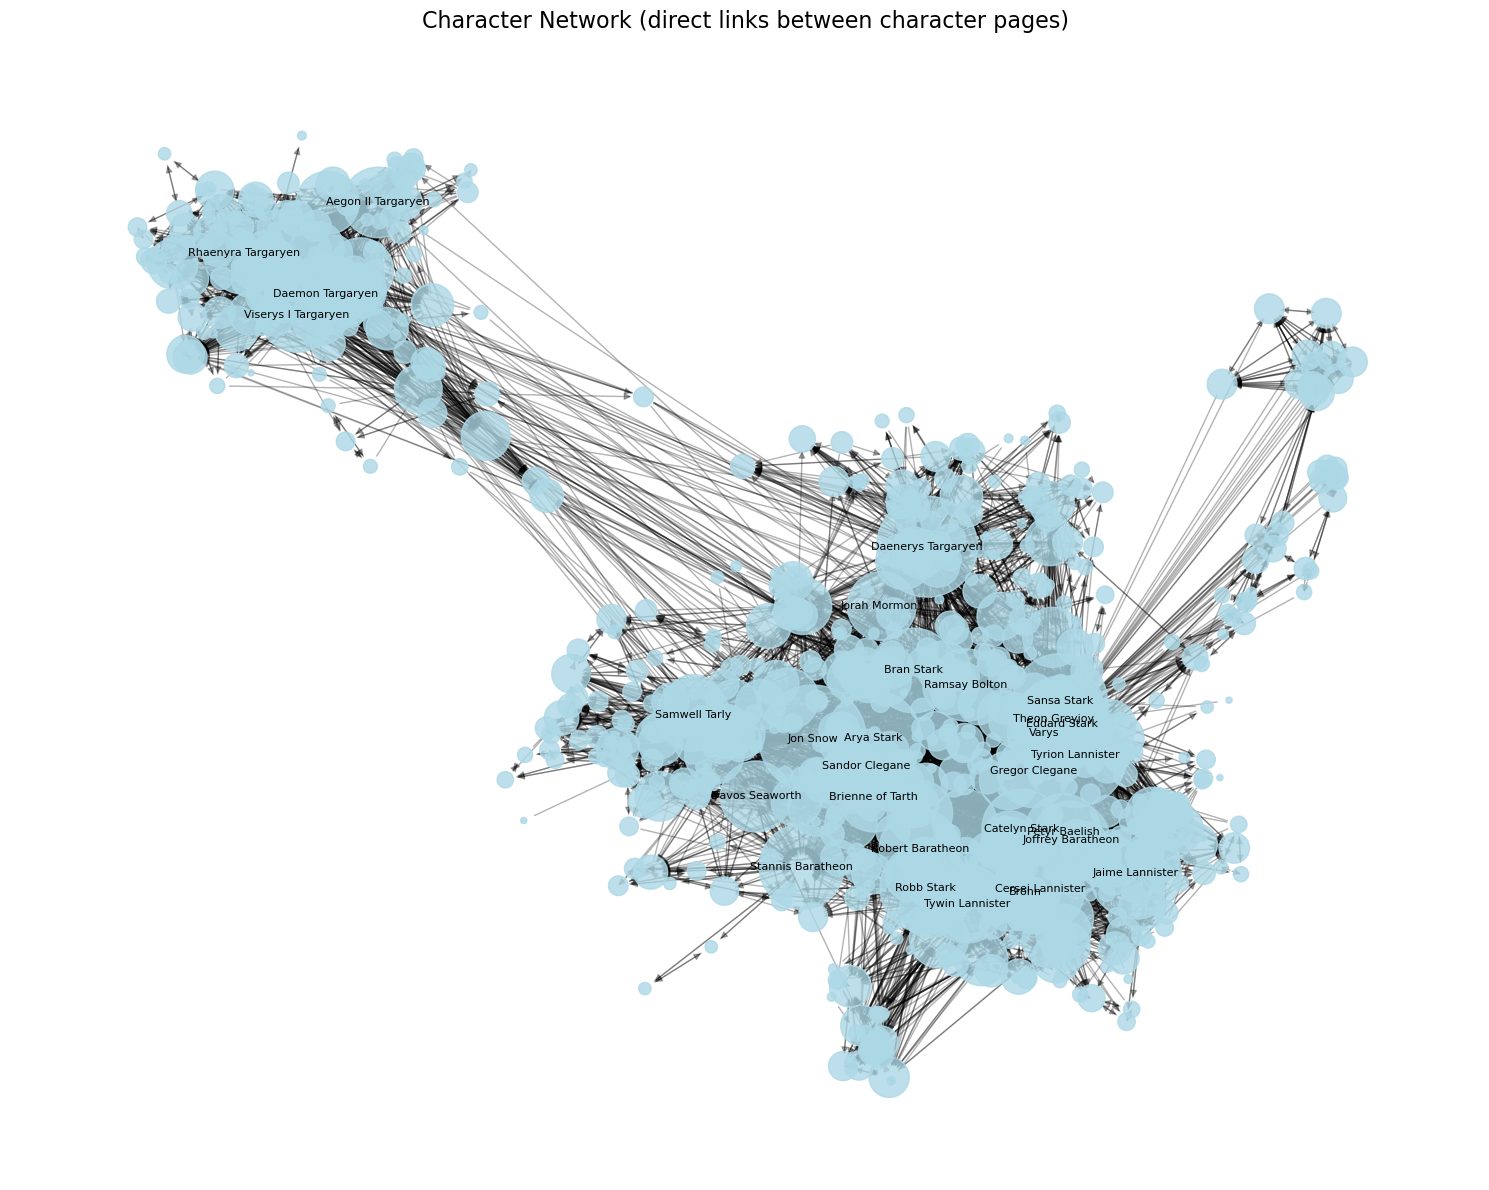

In [544]:
# Draw
fig, ax = plt.subplots(figsize=(15, 12))

nx.draw_networkx_edges(DG_characters_main, pos_unweighted, alpha=0.3, ax=ax)
nx.draw_networkx_nodes(DG_characters_main, pos_unweighted, node_size=node_sizes, 
                       node_color='lightblue', alpha=0.8, ax=ax)

# Label top nodes only
top_n = 30
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
labels = {node: node for node, _ in top_nodes}
nx.draw_networkx_labels(DG_characters_main, pos_unweighted, labels, font_size=8, ax=ax)

ax.set_title(f'Character Network (direct links between character pages)', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

In [545]:
# Example: Find connections for a specific character
char_name = 'Jon Snow'
if char_name in DG_characters.nodes():
    neighbors = list(DG_characters.neighbors(char_name))
    print(f"{char_name} is connected to {len(neighbors)} other characters")
    
    # print(f"\nDirect character connections:")
    # for i, other_char in enumerate(sorted(neighbors)[:15], 1):
    #     print(f"{i}. {other_char}")

Jon Snow is connected to 107 other characters


In [546]:
# Save the character network
with open(os.path.join('graphs', 'dg_characters.pickle'), 'wb') as f:
    pickle.dump(DG_characters, f)

print("Saved DG_characters to graphs/dg_characters.pickle")

Saved DG_characters to graphs/dg_characters.pickle


## Creating the weighted character network

In [547]:
# Create weighted graph as a copy of the unweighted graph
# Then add weights to the existing edges
DGW_characters = DG_characters.copy()

print(f"Copied unweighted graph: {DGW_characters.number_of_nodes()} nodes, {DGW_characters.number_of_edges()} edges")

Copied unweighted graph: 847 nodes, 10601 edges


In [548]:
def count_character_mentions(text: str, target_char: str, aka_names: list = None, page_char: str = None, page_aka_names: list = None) -> int:
    """Count all mentions of a character in text using full name, first name, and AKA names.
    Only counts mentions after the first wiki link to the character appears.
    
    Args:
        text: The text to search in
        target_char: The full character name to search for
        aka_names: List of alternative names for the character
        page_char: The character whose page this is (to avoid first-name conflicts)
        page_aka_names: List of AKA names for the page character (to avoid conflicts)
        
    Returns:
        Total count of mentions
    """
    if aka_names is None:
        aka_names = []
    if page_aka_names is None:
        page_aka_names = []
    
    # Special handling for Sam (baby) vs Samwell Tarly
    # If target is "Sam" and both Sam and Samwell Tarly exist in the graph, only count "baby"
    # If only Sam exists, count both "Sam" and "baby"
    is_baby_sam = False
    if target_char == "Sam":
        # Check if Samwell Tarly exists in DG_sections (if it exists, this Sam is the baby)
        if 'Samwell Tarly' in DG_sections.nodes():
            is_baby_sam = True
    
    # Titles that shouldn't trigger first-name counting
    title_prefixes = ['Lord', 'Lady', 'King', 'Queen', 'Ser', 'Maester', 'Grand Maester',
                      'Prince', 'Princess', 'Night', 'High']
    
    # Remove only specific infobox fields that shouldn't be counted
    # Keep relationship fields like Father, Mother, Siblings, Spouse, Lovers, Issue
    fields_to_remove = [
        'Title', 'Type', 'Image', 'Birth', 'Death', 'House', 'Affiliation', 'Titles', 
        'AKA', 'Culture', 'Religion', 'Arms', 'Series', 'Season', 'Seasons', 
        'Appeared in', 'Appearances', 'First', 'Last', 'DeathEp', 'Actor', 
        'Status', 'Origin', 'Allegiance'
    ]
    
    # Find the end of the infobox to start searching after it
    infobox_end = 0
    infobox_match = re.search(r'\{\{Character.*?\n\}\}', text, re.DOTALL | re.IGNORECASE)
    if infobox_match:
        infobox_end = infobox_match.end()
    
    # Look for first wiki link to target character (after infobox)
    # Pattern: [[target_char]] or [[target_char|display]]
    link_patterns = [
        r'\[\[' + re.escape(target_char) + r'(?:\|[^\]]+)?\]\]',
    ]
    
    first_link_pos = None
    for link_pattern in link_patterns:
        match = re.search(link_pattern, text[infobox_end:], re.IGNORECASE)
        if match:
            first_link_pos = infobox_end + match.start()
            break
    
    # If no link found, return 0 (character not mentioned on this page)
    if first_link_pos is None:
        return 0
    
    # Start count at 1 to include the first link itself as a mention
    total_count = 1
    
    # Only process text after the first link for additional mentions
    text_to_process = text[first_link_pos:]
    
    # Remove specific infobox fields from the text we're processing
    clean_text = text_to_process
    for field in fields_to_remove:
        pattern = r'\|\s*' + re.escape(field) + r'\s*=.*?(?=\n\s*\||}})'
        clean_text = re.sub(pattern, '', clean_text, flags=re.IGNORECASE | re.DOTALL)
    
    # Remove other wiki templates like {{Ref|...}}, {{C|...}}, etc.
    clean_text = re.sub(r'\{\{(?!.*?\[\[)([^}]+)\}\}', '', clean_text)
    
    # Remove [[...]] links but keep the display text
    clean_text = re.sub(r'\[\[([^\]|]+?)(?:\|([^\]]+?))?\]\]', lambda m: m.group(2) if m.group(2) else m.group(1), clean_text)
    
    # Note: total_count already initialized to 1 (for the first link)
    
    # Special case: if this is baby Sam (when Samwell Tarly exists), only count "baby"
    if is_baby_sam:
        # Only count mentions of "baby" (case-insensitive for common nouns)
        pattern = r'\b' + re.escape("baby") + r"(?:'s)?\b"
        for match in re.finditer(pattern, clean_text, re.IGNORECASE):
            total_count += 1
        return total_count
    
    # Determine first name and whether to use it
    first_name = None
    use_first_name = False
    
    if ' ' in target_char:
        first_name = target_char.split()[0]
        
        # Check if first name is a title that shouldn't be counted
        if first_name not in title_prefixes:
            # Check if page character has same first name (e.g., Jon Snow page searching for Jon Roxton)
            if page_char and ' ' in page_char:
                page_first_name = page_char.split()[0]
                if page_first_name != first_name:
                    use_first_name = True
            else:
                use_first_name = True
    
    # Find all positions where the full name matches
    full_name_positions = set()
    if target_char:
        # For single-word names, use case-sensitive matching to avoid common words
        # For multi-word names, require first letter case match but rest can be case-insensitive
        if ' ' not in target_char:
            # Single word name - fully case-sensitive (e.g., "Will" won't match "will")
            pattern = r'\b' + re.escape(target_char) + r"(?:'s)?\b"
            for match in re.finditer(pattern, clean_text):
                full_name_positions.update(range(match.start(), match.end()))
                total_count += 1
        else:
            # Multi-word name - first letter must match case, rest case-insensitive
            first_letter = re.escape(target_char[0])
            rest_of_name = re.escape(target_char[1:])
            pattern = r'\b' + first_letter + rest_of_name + r"(?:'s)?\b"
            for match in re.finditer(pattern, clean_text, re.IGNORECASE):
                full_name_positions.update(range(match.start(), match.end()))
                total_count += 1
    
    # Count first name matches (if applicable), but skip overlaps with full name
    # Also check if first name matches any of the page character's AKA names
    if use_first_name and first_name:
        # Check if this first name is one of the page character's AKA names
        first_name_is_page_aka = any(first_name.lower() == aka.lower() for aka in page_aka_names)
        
        if not first_name_is_page_aka:
            # Use case-sensitive matching for first names to avoid common words
            pattern = r'\b' + re.escape(first_name) + r"(?:'s)?\b"
            for match in re.finditer(pattern, clean_text):
                if match.start() not in full_name_positions:
                    total_count += 1
                    # Mark these positions as used too
                    for pos in range(match.start(), match.end()):
                        full_name_positions.add(pos)
    
    # Count AKA name matches, skipping overlaps
    # Also check if AKA name matches page character's AKA names
    for aka_name in aka_names:
        # Check if this AKA name is one of the page character's AKA names
        aka_is_page_aka = any(aka_name.lower() == page_aka.lower() for page_aka in page_aka_names)
        
        if not aka_is_page_aka and aka_name:
            # Use case-sensitive matching for AKA names to avoid common words
            pattern = r'\b' + re.escape(aka_name) + r"(?:'s)?\b"
            for match in re.finditer(pattern, clean_text):
                if match.start() not in full_name_positions:
                    total_count += 1
    
    return total_count

# Test on Jon Snow's page mentioning another character
test_char = 'Jon Snow'
target = 'Arya Stark'
aka = DG_sections.nodes.get(target, {}).get('also_known_as', [])
page_aka = DG_sections.nodes.get(test_char, {}).get('also_known_as', [])

if test_char in page_texts:
    test_text = page_texts[test_char]
    
    # Test the function
    count = count_character_mentions(test_text, target, aka, page_char=test_char, page_aka_names=page_aka)
    print(f"Count for '{target}' (aka: {aka}): {count}")
    
    # Also show where matches occur for debugging
    clean_text = test_text
    
    # Remove specific fields
    fields_to_remove = [
        'Title', 'Type', 'Image', 'Birth', 'Death', 'House', 'Affiliation', 'Titles', 
        'AKA', 'Culture', 'Religion', 'Arms', 'Series', 'Season', 'Seasons', 
        'Appeared in', 'Appearances', 'First', 'Last', 'DeathEp', 'Actor', 
        'Status', 'Origin', 'Allegiance'
    ]
    
    for field in fields_to_remove:
        pattern = r'\|\s*' + re.escape(field) + r'\s*=.*?(?=\n\s*\||}})'
        clean_text = re.sub(pattern, '', clean_text, flags=re.IGNORECASE | re.DOTALL)
    
    clean_text = re.sub(r'\{\{(?!.*?\[\[)([^}]+)\}\}', '', clean_text)
    clean_text = re.sub(r'\[\[([^\]|]+?)(?:\|([^\]]+?))?\]\]', lambda m: m.group(2) if m.group(2) else m.group(1), clean_text)
    
    # Create list of all name variants to search for
    names_to_find = [target]
    if ' ' in target:
        names_to_find.append(target.split()[0])
    names_to_find.extend(aka)
    
    # Find each mention with context
    print(f"\nSearching for: {names_to_find}")
    for name in names_to_find:
        pattern = r'\b' + re.escape(name) + r"(?:'s)?\b"
        for match in re.finditer(pattern, clean_text):
            start = max(0, match.start() - 80)
            end = min(len(clean_text), match.end() + 80)
            
            context = clean_text[start:end]
            # Highlight the matched name
            context_display = context[:match.start()-start] + f"**{match.group()}**" + context[match.end()-start:]
            
            print(f"\nName variant: '{name}'")
            print(f"...{context_display}...")

Count for 'Arya Stark' (aka: ['Arry', 'Lanna', 'Mercy']): 24

Searching for: ['Arya Stark', 'Arya', 'Arry', 'Lanna', 'Mercy']

Name variant: 'Arya'
...Lord Eddard's ward, Theon Greyjoy. However, Jon's closest relationship was with **Arya**, who, as an adventurous tomboy prone to un-ladylike pursuits, also felt like a ...

Name variant: 'Arya'
... says goodbye to the unconscious Bran, who has been injured in a fall. He gives **Arya** a sword named Needle that he had made especially for her, advising her to "stic...

Name variant: 'Arya'
...nd Daenerys kiss, which is interrupted by the dragons. Later, Jon reunites with **Arya**, he finds out that she is more loyal to Sansa than the Targaryen queen.

Later ...

Name variant: 'Arya'
...they seem to fall off to the ground one by one as the Night King is defeated by **Arya**.

After the battle, Jon leads a mass cremation for the dead and is hailed by th...

Name variant: 'Arya'
...owever, assures the queen that they will obey her command. Af

In [549]:
# Add weights to existing edges by counting mentions
# We only need to check edges that already exist in the graph

print("Adding weights to character network...")
print(f"Processing {DGW_characters.number_of_edges()} edges...")

edges_processed = 0

for source_char, target_char in DGW_characters.edges():    
    # Get the text for the source character's page
    if source_char not in page_texts:
        # If page doesn't exist, set weight to 1 (for the link itself)
        DGW_characters[source_char][target_char]['weight'] = 1
        continue
    
    source_text = page_texts[source_char]
    
    # Get AKA names for target character
    aka_names = DG_sections.nodes[target_char].get('also_known_as', [])
    
    # Get AKA names for page character (to avoid counting page char's own AKA names)
    page_aka_names = DG_sections.nodes[source_char].get('also_known_as', [])
    
    # Count mentions (this will be at least 1 because the link exists)
    mention_count = count_character_mentions(source_text, target_char, aka_names, 
                                            page_char=source_char, page_aka_names=page_aka_names)
    
    # Add weight to edge
    DGW_characters[source_char][target_char]['weight'] = mention_count

print(f"\nWeighted character network complete!")
print(f"  Nodes: {DGW_characters.number_of_nodes()}")
print(f"  Edges: {DGW_characters.number_of_edges()}")

Adding weights to character network...
Processing 10601 edges...

Weighted character network complete!
  Nodes: 847
  Edges: 10601

Weighted character network complete!
  Nodes: 847
  Edges: 10601


In [550]:
# Compare Jon Snow's edges in weighted vs unweighted graph
char_name = 'Jon Snow'

print(f"=== Comparison for {char_name} ===\n")

# Unweighted graph (DG_characters) - directed, no weights
if char_name in DG_characters.nodes():
    out_neighbors_unw = list(DG_characters.successors(char_name))
    in_neighbors_unw = list(DG_characters.predecessors(char_name))
    
    print(f"UNWEIGHTED GRAPH (DG_characters):")
    print(f"  Type: Directed (based on wiki links)")
    print(f"  Outgoing edges: {len(out_neighbors_unw)} (characters linked from Jon's page)")
    print(f"  Incoming edges: {len(in_neighbors_unw)} (characters that link to Jon)")
    print(f"  Total unique connections: {len(set(out_neighbors_unw) | set(in_neighbors_unw))}")
    
    if out_neighbors_unw:
        print(f"\n  Characters linked from Jon Snow's page (first 10):")
        for i, target in enumerate(sorted(out_neighbors_unw)[:10], 1):
            print(f"    {i}. {target}")

print("\n" + "="*60 + "\n")

# Weighted graph (DGW_characters) - directed
if char_name in DGW_characters.nodes():
    # Outgoing edges (characters mentioned ON Jon Snow's page)
    out_neighbors = list(DGW_characters.successors(char_name))
    out_edges_weighted = [(target, DGW_characters[char_name][target]['weight']) 
                          for target in out_neighbors]
    out_edges_sorted = sorted(out_edges_weighted, key=lambda x: x[1], reverse=True)
    
    # Incoming edges (characters that mention Jon Snow on THEIR pages)
    in_neighbors = list(DGW_characters.predecessors(char_name))
    in_edges_weighted = [(source, DGW_characters[source][char_name]['weight']) 
                         for source in in_neighbors]
    in_edges_sorted = sorted(in_edges_weighted, key=lambda x: x[1], reverse=True)
    
    print(f"WEIGHTED GRAPH (DGW_characters):")
    print(f"  Type: Directed (based on text mentions)")
    print(f"  Outgoing edges: {len(out_neighbors)} (characters mentioned on Jon's page)")
    print(f"  Incoming edges: {len(in_neighbors)} (characters that mention Jon)")
    print(f"  Total unique connections: {len(set(out_neighbors) | set(in_neighbors))}")
    
    print(f"\n  Top 10 characters mentioned ON Jon Snow's page:")
    for i, (target, weight) in enumerate(out_edges_sorted[:10], 1):
        print(f"    {i}. {target}: {weight} mentions")
    
    print(f"\n  Top 10 characters that mention Jon Snow on THEIR pages:")
    for i, (source, weight) in enumerate(in_edges_sorted[:10], 1):
        print(f"    {i}. {source}: {weight} mentions")

print("\n" + "="*60 + "\n")

# # Find differences
# if char_name in DG_characters.nodes() and char_name in DGW_characters.nodes():
#     unweighted_out_set = set(out_neighbors_unw)
#     unweighted_in_set = set(in_neighbors_unw)
#     unweighted_all_set = unweighted_out_set | unweighted_in_set
#     weighted_out_set = set(out_neighbors)
#     weighted_in_set = set(in_neighbors)
#     weighted_all_set = weighted_out_set | weighted_in_set
    
#     # Characters in unweighted but not in weighted
#     only_unweighted = unweighted_all_set - weighted_all_set
#     # Characters in weighted but not in unweighted
#     only_weighted = weighted_all_set - unweighted_all_set
#     # Characters in both
#     in_both = unweighted_all_set & weighted_all_set
    
#     print(f"COMPARISON:")
#     print(f"  In both graphs: {len(in_both)} characters")
#     print(f"  Only in unweighted (linked but not mentioned): {len(only_unweighted)}")
#     if only_unweighted:
#         print(f"    Examples: {list(only_unweighted)[:5]}")
#     print(f"  Only in weighted (mentioned but not linked): {len(only_weighted)}")
#     if only_weighted:
#         print(f"    Examples: {list(only_weighted)[:5]}")


=== Comparison for Jon Snow ===

UNWEIGHTED GRAPH (DG_characters):
  Type: Directed (based on wiki links)
  Outgoing edges: 107 (characters linked from Jon's page)
  Incoming edges: 192 (characters that link to Jon)
  Total unique connections: 201

  Characters linked from Jon Snow's page (first 10):
    1. Aemon
    2. Aerys II Targaryen
    3. Alliser Thorne
    4. Alys Karstark
    5. Arthur Dayne
    6. Arya Stark
    7. Bastard's girls
    8. Benjen Stark
    9. Beric Dondarrion
    10. Bowen Marsh


WEIGHTED GRAPH (DGW_characters):
  Type: Directed (based on text mentions)
  Outgoing edges: 107 (characters mentioned on Jon's page)
  Incoming edges: 192 (characters that mention Jon)
  Total unique connections: 201

  Top 10 characters mentioned ON Jon Snow's page:
    1. Daenerys Targaryen: 135 mentions
    2. Sansa Stark: 86 mentions
    3. Eddard Stark: 65 mentions
    4. Mance Rayder: 65 mentions
    5. Samwell Tarly: 64 mentions
    6. Tyrion Lannister: 63 mentions
    7. Rams

In [551]:
# Analyze the weighted network
# Show top edges by weight

edge_weights = [(u, v, data['weight']) for u, v, data in DGW_characters.edges(data=True)]
edge_weights_sorted = sorted(edge_weights, key=lambda x: x[2], reverse=True)

print("Top 20 character connections by mention count:")
for i, (source, target, weight) in enumerate(edge_weights_sorted[:20], 1):
    print(f"{i}. {source} → {target}: {weight} mentions")

# Show statistics
weights = [w for _, _, w in edge_weights]
print(f"\nWeight statistics:")
print(f"  Mean weight: {sum(weights) / len(weights):.2f}")
print(f"  Max weight: {max(weights)}")
print(f"  Min weight: {min(weights)}")
print(f"  Total mentions tracked: {sum(weights)}")

Top 20 character connections by mention count:
1. Jorah Mormont → Daenerys Targaryen: 285 mentions
2. Daenerys Targaryen → Jon Snow: 240 mentions
3. Tyrion Lannister → Daenerys Targaryen: 199 mentions
4. Jaime Lannister → Cersei Lannister: 198 mentions
5. Tormund → Jon Snow: 190 mentions
6. Alicent Hightower → Rhaenyra Targaryen: 185 mentions
7. Ramsay Bolton → Theon Greyjoy: 177 mentions
8. Sansa Stark → Jon Snow: 169 mentions
9. Theon Greyjoy → Ramsay Bolton: 166 mentions
10. Cersei Lannister → Jaime Lannister: 164 mentions
11. Varys → Tyrion Lannister: 158 mentions
12. Gilly → Samwell Tarly: 156 mentions
13. Tywin Lannister → Tyrion Lannister: 155 mentions
14. Daemon Targaryen → Rhaenyra Targaryen: 154 mentions
15. Bronn → Tyrion Lannister: 153 mentions
16. Cersei Lannister → Tyrion Lannister: 151 mentions
17. Davos Seaworth → Stannis Baratheon: 150 mentions
18. Alliser Thorne → Jon Snow: 149 mentions
19. Petyr Baelish → Sansa Stark: 148 mentions
20. Shae → Tyrion Lannister: 144 men

In [552]:
# Example: Check mentions for a specific character
check_char = 'Jon Snow'

if check_char in DGW_characters.nodes():
    # Outgoing edges (who Jon Snow mentions)
    out_edges = [(target, DGW_characters[check_char][target]['weight']) 
                 for target in DGW_characters.successors(check_char)]
    out_edges_sorted = sorted(out_edges, key=lambda x: x[1], reverse=True)
    
    print(f"Top 10 characters mentioned on {check_char}'s page:")
    for i, (target, weight) in enumerate(out_edges_sorted[:10], 1):
        print(f"  {i}. {target}: {weight} mentions")
    
    # Incoming edges (who mentions Jon Snow)
    in_edges = [(source, DGW_characters[source][check_char]['weight']) 
                for source in DGW_characters.predecessors(check_char)]
    in_edges_sorted = sorted(in_edges, key=lambda x: x[1], reverse=True)
    
    print(f"\nTop 10 characters that mention {check_char} on their pages:")
    for i, (source, weight) in enumerate(in_edges_sorted[:10], 1):
        print(f"  {i}. {source}: {weight} mentions")

Top 10 characters mentioned on Jon Snow's page:
  1. Daenerys Targaryen: 135 mentions
  2. Sansa Stark: 86 mentions
  3. Eddard Stark: 65 mentions
  4. Mance Rayder: 65 mentions
  5. Samwell Tarly: 64 mentions
  6. Tyrion Lannister: 63 mentions
  7. Ramsay Bolton: 60 mentions
  8. Stannis Baratheon: 60 mentions
  9. Ygritte: 59 mentions
  10. Davos Seaworth: 50 mentions

Top 10 characters that mention Jon Snow on their pages:
  1. Daenerys Targaryen: 240 mentions
  2. Tormund: 190 mentions
  3. Sansa Stark: 169 mentions
  4. Alliser Thorne: 149 mentions
  5. Ygritte: 134 mentions
  6. Davos Seaworth: 126 mentions
  7. Samwell Tarly: 125 mentions
  8. Eddison Tollett: 94 mentions
  9. Ramsay Bolton: 88 mentions
  10. Eddard Stark: 86 mentions


In [553]:
# Save the weighted character network
with open(os.path.join('graphs', 'dgw_characters.pickle'), 'wb') as f:
    pickle.dump(DGW_characters, f)

print("Saved DGW_characters to graphs/dgw_characters.pickle")

Saved DGW_characters to graphs/dgw_characters.pickle


In [554]:
# Visualize the weighted character network

# Get largest connected component for visualization

largest_cc_weighted = max(nx.weakly_connected_components(DGW_characters), key=len)
DGW_main = DGW_characters.subgraph(largest_cc_weighted).copy()

print(f"Visualizing weighted character network: {DGW_main.number_of_nodes()} nodes, {DGW_main.number_of_edges()} edges")

# Calculate layout
pos_weighted = nx.forceatlas2_layout(DGW_main)

Visualizing weighted character network: 818 nodes, 10392 edges


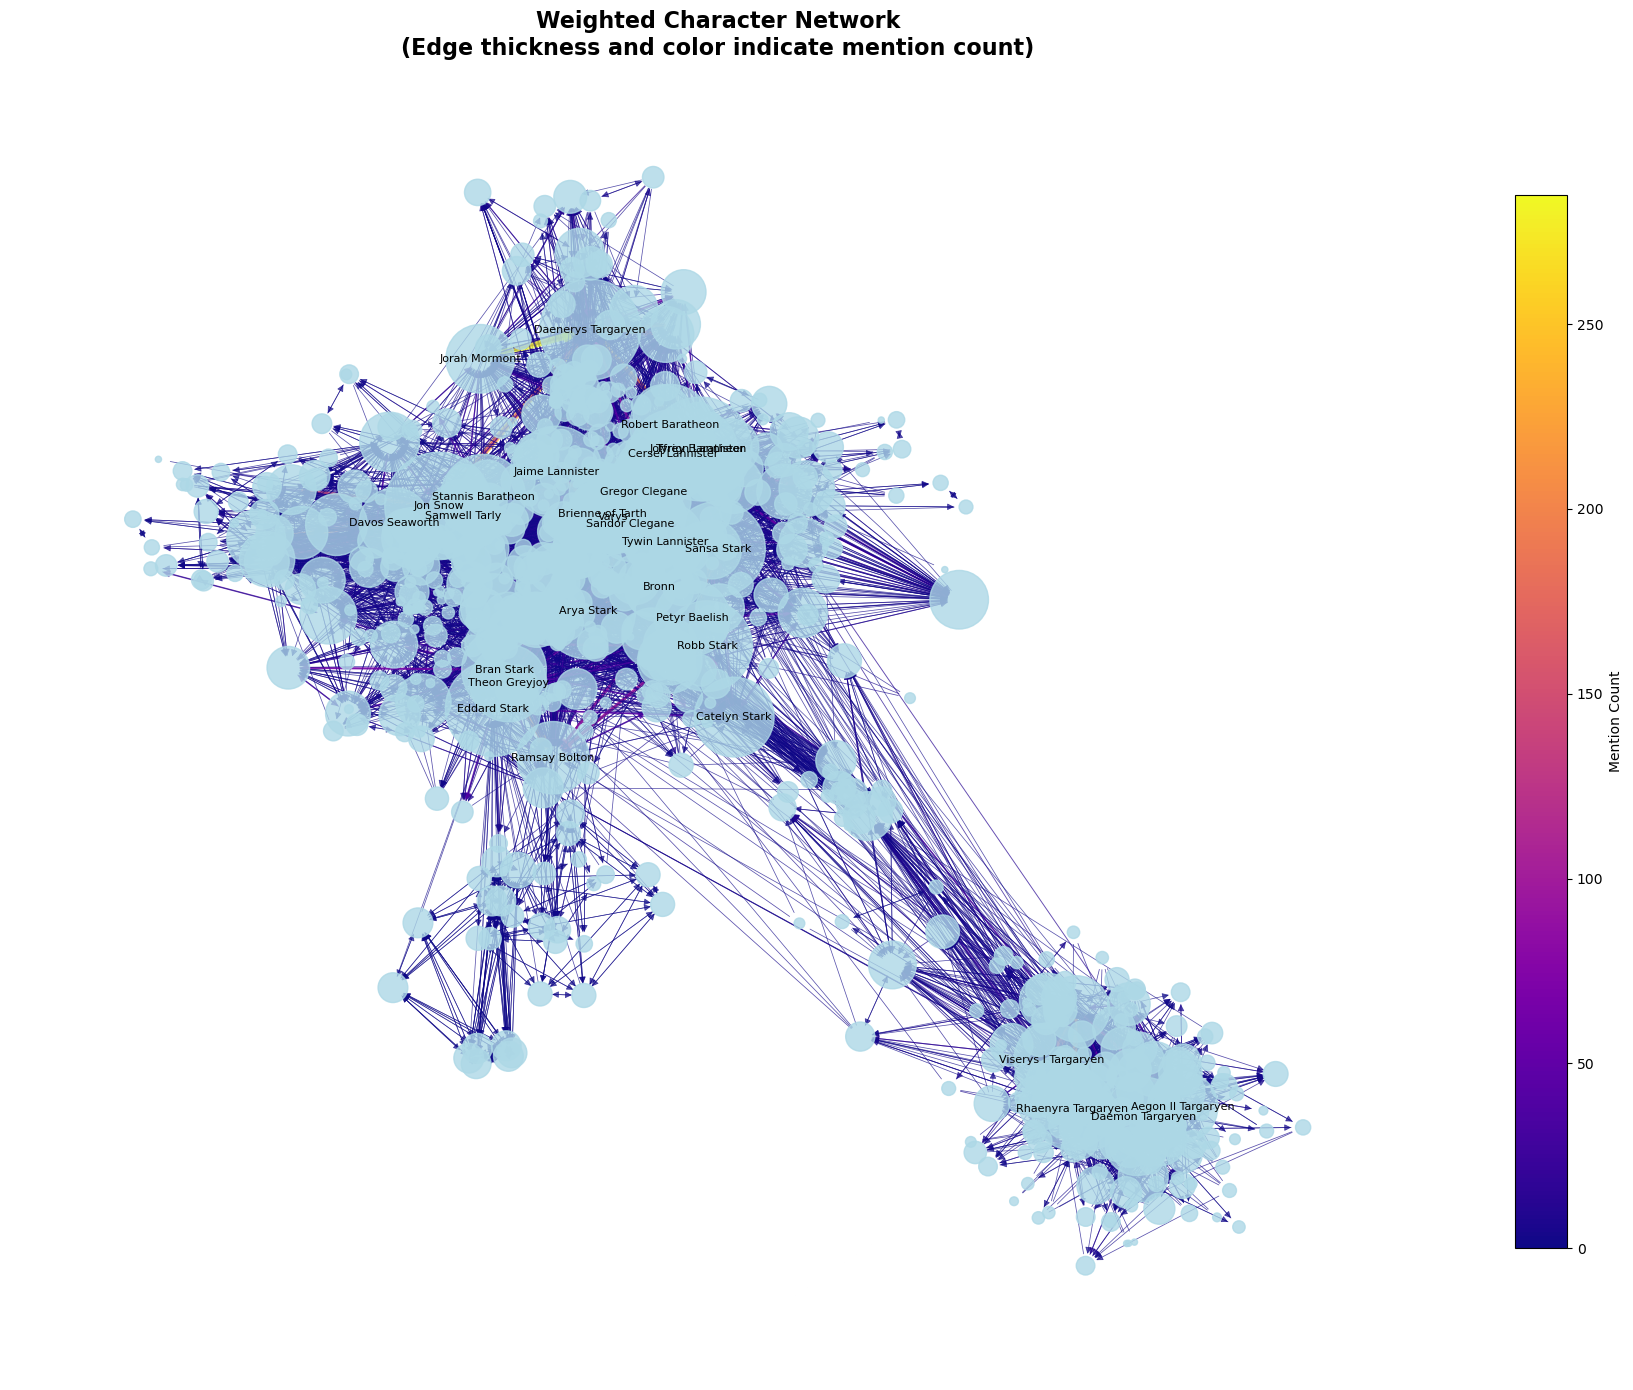


Weight statistics:
  Min weight: 0
  Max weight: 285
  Mean weight: 7.30
  Median weight: 3.00


In [555]:
# Get edge weights for visualization
edges = DGW_main.edges()
weights = [DGW_main[u][v]['weight'] for u, v in edges]

# Normalize weights for visualization (edge width)
max_weight = max(weights)
min_weight = min(weights)
# Scale edge widths between 0.5 and 5
edge_widths = [0.5 + 4.5 * (w - min_weight) / (max_weight - min_weight) if max_weight > min_weight else 2 for w in weights]

# Normalize weights for color mapping
edge_colors = weights

# Node sizes by degree
degrees = dict(DGW_main.degree())
node_sizes = [degrees[n] * 20 for n in DGW_main.nodes()]

# Draw
fig, ax = plt.subplots(figsize=(18, 14))

# Draw edges with varying widths and colors based on weight
edges_collection = nx.draw_networkx_edges(
    DGW_main, pos_weighted, 
    width=edge_widths,
    edge_color=edge_colors,
    edge_cmap=plt.cm.plasma,
    edge_vmin=min_weight,
    edge_vmax=max_weight,
    alpha=0.7,
    arrows=True,
    arrowsize=10,
    ax=ax
)

# Draw nodes
nx.draw_networkx_nodes(DGW_main, pos_weighted, node_size=node_sizes, 
                        node_color='lightblue', alpha=0.8, ax=ax)

# Label top nodes only
top_n = 30
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
labels = {node: node for node, _ in top_nodes}
nx.draw_networkx_labels(DGW_main, pos_weighted, labels, font_size=8, ax=ax)

# Add colorbar for edge weights
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, 
                            norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Mention Count', shrink=0.8)

ax.set_title('Weighted Character Network\n(Edge thickness and color indicate mention count)', 
                fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"\nWeight statistics:")
print(f"  Min weight: {min_weight}")
print(f"  Max weight: {max_weight}")
print(f"  Mean weight: {np.mean(weights):.2f}")
print(f"  Median weight: {np.median(weights):.2f}")

In [556]:
# Visualize weighted character network with node sizes by weighted in-degree
# Use the same connected component
largest_cc_weighted_indegree = max(nx.weakly_connected_components(DGW_characters), key=len)
DGW_main_indegree = DGW_characters.subgraph(largest_cc_weighted_indegree).copy()

print(f"Visualizing weighted character network by in-degree: {DGW_main_indegree.number_of_nodes()} nodes, {DGW_main_indegree.number_of_edges()} edges")

# Calculate layout (same as previous for consistency)
pos_weighted_indegree = nx.forceatlas2_layout(DGW_main_indegree)

Visualizing weighted character network by in-degree: 818 nodes, 10392 edges


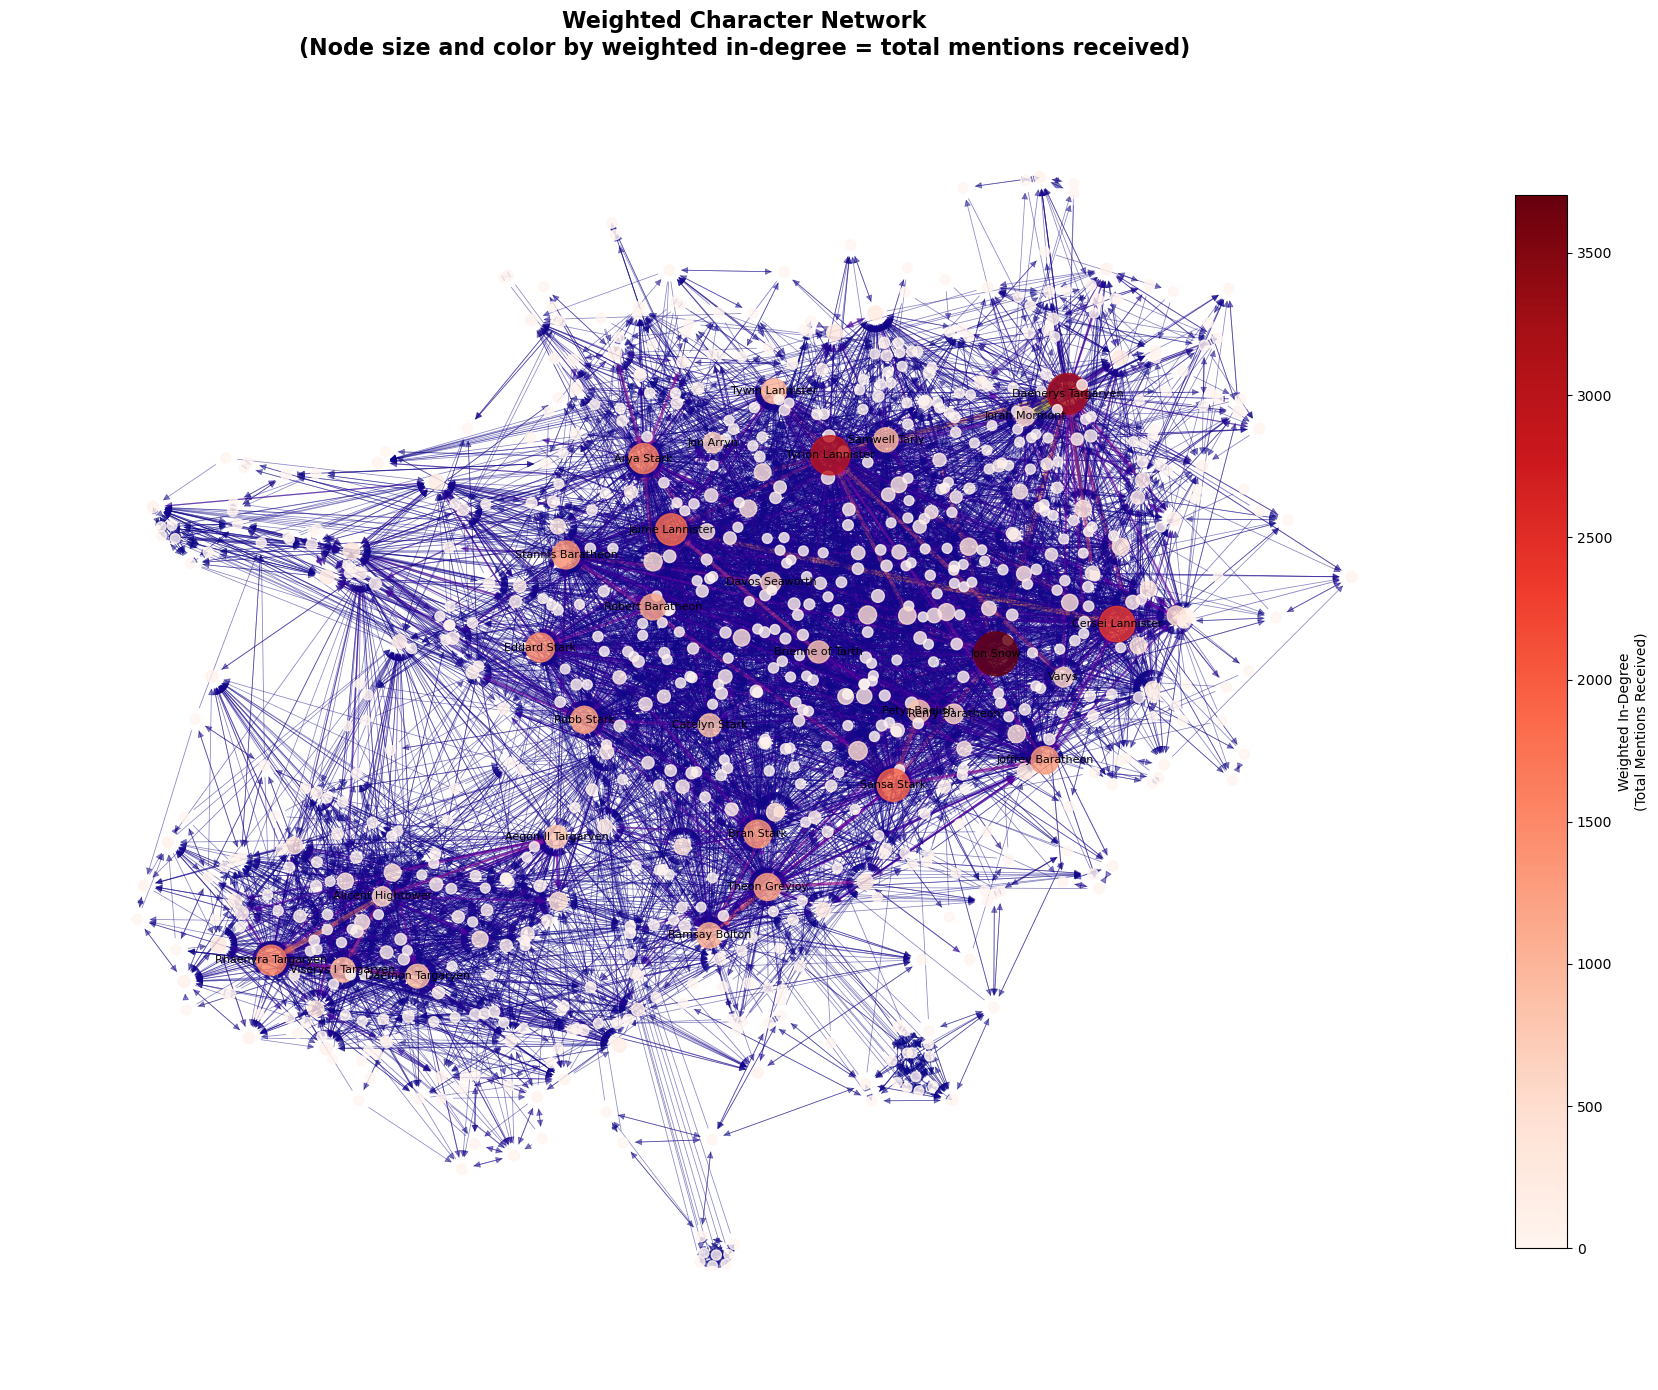


Weighted In-Degree statistics:
  Min: 0
  Max: 3705
  Mean: 92.79
  Median: 11.50

Top 10 characters by weighted in-degree (most mentioned):
  1. Jon Snow: 3705 total mentions received
  2. Daenerys Targaryen: 3121 total mentions received
  3. Tyrion Lannister: 2919 total mentions received
  4. Cersei Lannister: 2354 total mentions received
  5. Sansa Stark: 1926 total mentions received
  6. Jaime Lannister: 1812 total mentions received
  7. Arya Stark: 1621 total mentions received
  8. Rhaenyra Targaryen: 1606 total mentions received
  9. Eddard Stark: 1488 total mentions received
  10. Stannis Baratheon: 1383 total mentions received


In [557]:
# Calculate weighted in-degree (sum of weights of incoming edges)
weighted_in_degree = {}
for node in DGW_main_indegree.nodes():
    in_edges = DGW_main_indegree.in_edges(node, data=True)
    total_weight = sum(data['weight'] for _, _, data in in_edges)
    weighted_in_degree[node] = total_weight

# Get edge weights for visualization
edges = DGW_main_indegree.edges()
weights = [DGW_main_indegree[u][v]['weight'] for u, v in edges]

# Normalize weights for visualization (edge width)
max_weight = max(weights)
min_weight = min(weights)
edge_widths = [0.5 + 4.5 * (w - min_weight) / (max_weight - min_weight) if max_weight > min_weight else 2 for w in weights]
edge_colors = weights

# Node sizes by weighted in-degree
max_in_degree = max(weighted_in_degree.values()) if weighted_in_degree else 1
min_in_degree = min(weighted_in_degree.values()) if weighted_in_degree else 0
node_sizes = [50 + 950 * (weighted_in_degree[n] - min_in_degree) / (max_in_degree - min_in_degree) 
              if max_in_degree > min_in_degree else 500 
              for n in DGW_main_indegree.nodes()]

# Node colors by weighted in-degree
node_colors = [weighted_in_degree[n] for n in DGW_main_indegree.nodes()]

# Draw
fig, ax = plt.subplots(figsize=(18, 14))

# Draw edges
nx.draw_networkx_edges(
    DGW_main_indegree, pos_weighted_indegree, 
    width=edge_widths,
    edge_color=edge_colors,
    edge_cmap=plt.cm.plasma,
    edge_vmin=min_weight,
    edge_vmax=max_weight,
    alpha=0.5,
    arrows=True,
    arrowsize=10,
    ax=ax
)

# Draw nodes with color and size based on weighted in-degree
nodes_collection = nx.draw_networkx_nodes(
    DGW_main_indegree, pos_weighted_indegree, 
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.Reds,
    vmin=min_in_degree,
    vmax=max_in_degree,
    alpha=0.8,
    ax=ax
)

# Label top nodes by weighted in-degree
top_n = 30
top_nodes_by_in_degree = sorted(weighted_in_degree.items(), key=lambda x: x[1], reverse=True)[:top_n]
labels = {node: node for node, _ in top_nodes_by_in_degree}
nx.draw_networkx_labels(DGW_main_indegree, pos_weighted_indegree, labels, font_size=8, ax=ax)

# Add colorbar for node colors (weighted in-degree)
sm_nodes = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                                 norm=plt.Normalize(vmin=min_in_degree, vmax=max_in_degree))
sm_nodes.set_array([])
cbar_nodes = plt.colorbar(sm_nodes, ax=ax, label='Weighted In-Degree\n(Total Mentions Received)', 
                          shrink=0.8, pad=0.02)

ax.set_title('Weighted Character Network\n(Node size and color by weighted in-degree = total mentions received)', 
             fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()



In [558]:
print(f"\nWeighted In-Degree statistics:")
print(f"  Min: {min_in_degree}")
print(f"  Max: {max_in_degree}")
print(f"  Mean: {np.mean(list(weighted_in_degree.values())):.2f}")
print(f"  Median: {np.median(list(weighted_in_degree.values())):.2f}")

print(f"\nTop 10 characters by weighted in-degree (most mentioned):")
for i, (char, weight) in enumerate(top_nodes_by_in_degree[:20], 1):
    print(f"  {i}. {char}: {weight} total mentions received")





Weighted In-Degree statistics:
  Min: 0
  Max: 3705
  Mean: 92.79
  Median: 11.50

Top 10 characters by weighted in-degree (most mentioned):
  1. Jon Snow: 3705 total mentions received
  2. Daenerys Targaryen: 3121 total mentions received
  3. Tyrion Lannister: 2919 total mentions received
  4. Cersei Lannister: 2354 total mentions received
  5. Sansa Stark: 1926 total mentions received
  6. Jaime Lannister: 1812 total mentions received
  7. Arya Stark: 1621 total mentions received
  8. Rhaenyra Targaryen: 1606 total mentions received
  9. Eddard Stark: 1488 total mentions received
  10. Stannis Baratheon: 1383 total mentions received
  11. Bran Stark: 1349 total mentions received
  12. Joffrey Baratheon: 1337 total mentions received
  13. Robb Stark: 1284 total mentions received
  14. Theon Greyjoy: 1269 total mentions received
  15. Robert Baratheon: 1154 total mentions received
  16. Ramsay Bolton: 1096 total mentions received
  17. Tywin Lannister: 1051 total mentions received
  1

In [559]:
# Analyze most connected characters
char_degrees = dict(DG_characters.degree())
top_chars = sorted(char_degrees.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 most connected characters (by degree):")
for i, (char, degree) in enumerate(top_chars, 1):
    print(f"{i}. {char}: {degree}")

Top 20 most connected characters (by degree):
1. Jon Snow: 299
2. Tyrion Lannister: 279
3. Daenerys Targaryen: 264
4. Eddard Stark: 236
5. Arya Stark: 236
6. Sansa Stark: 233
7. Jaime Lannister: 220
8. Robb Stark: 213
9. Cersei Lannister: 208
10. Stannis Baratheon: 187
11. Bran Stark: 186
12. Rhaenyra Targaryen: 177
13. Robert Baratheon: 171
14. Daemon Targaryen: 168
15. Catelyn Stark: 165
16. Tywin Lannister: 161
17. Joffrey Baratheon: 159
18. Theon Greyjoy: 154
19. Petyr Baelish: 148
20. Viserys I Targaryen: 146


In [565]:
top_nodes_by_in_degree[:20]

[('Jon Snow', 3705),
 ('Daenerys Targaryen', 3121),
 ('Tyrion Lannister', 2919),
 ('Cersei Lannister', 2354),
 ('Sansa Stark', 1926),
 ('Jaime Lannister', 1812),
 ('Arya Stark', 1621),
 ('Rhaenyra Targaryen', 1606),
 ('Eddard Stark', 1488),
 ('Stannis Baratheon', 1383),
 ('Bran Stark', 1349),
 ('Joffrey Baratheon', 1337),
 ('Robb Stark', 1284),
 ('Theon Greyjoy', 1269),
 ('Robert Baratheon', 1154),
 ('Ramsay Bolton', 1096),
 ('Tywin Lannister', 1051),
 ('Viserys I Targaryen', 1001),
 ('Samwell Tarly', 995),
 ('Daemon Targaryen', 930)]

In [567]:
top_no_count = []
for row in top_nodes_by_in_degree[:20]:
    top_no_count.append(row[0])
    
for char in top_chars[:20]:
    if char[0] not in top_no_count:
        print(char[0])

Catelyn Stark
Petyr Baelish


## Moving some files

In [96]:
# Move files containing "#In the books" to Doubles subfolder

source_folder = 'GoT_files'
target_folder = os.path.join('GoT_files', 'Doubles')

# Create target folder if it doesn't exist
os.makedirs(target_folder, exist_ok=True)

# Get all files in source folder
files = os.listdir(source_folder)

moved_count = 0
for filename in files:
    if '#In the books' in filename:
        source_path = os.path.join(source_folder, filename)
        target_path = os.path.join(target_folder, filename)
        
        # Only move if it's a file (not a directory)
        if os.path.isfile(source_path):
            shutil.move(source_path, target_path)
            moved_count += 1
            print(f"Moved: {filename}")

print(f"\nTotal files moved: {moved_count}")

Moved: Aegon Targaryen (son of Elia Martell)#In the books.txt
Moved: Alton Lannister#In the books.txt
Moved: Benjen Stark#In the books.txt
Moved: Bloody Gate#In the books.txt
Moved: Catelyn Stark#In the books.txt
Moved: Clea#In the books.txt
Moved: Garth the Gardener#In the books.txt
Moved: Gregor Clegane#In the books.txt
Moved: Harald Karstark#In the books.txt
Moved: Jaqen H'ghar#In the books.txt
Moved: Jon Connington#In the books.txt
Moved: Karl Tanner#In the books.txt
Moved: Kinvara#In the books.txt
Moved: Lady Mallister#In the books.txt
Moved: Locke#In the books.txt
Moved: Lord Blackmont#In the books.txt
Moved: Martyn Lannister#In the books.txt
Moved: Matthos Seaworth#In the books.txt
Moved: Mellos#In the books.txt
Moved: Meryn Trant#In the books.txt
Moved: Myranda#In the books.txt
Moved: Alton Lannister#In the books.txt
Moved: Benjen Stark#In the books.txt
Moved: Bloody Gate#In the books.txt
Moved: Catelyn Stark#In the books.txt
Moved: Clea#In the books.txt
Moved: Garth the Garden